# Basic Visusalisation 

In [1]:
from birdy import WPSClient
from os import listdir, path

from shutil import move
from os.path import join

In [2]:
# To display Images from an url
from IPython.core.display import HTML
from IPython.display import Image

In [10]:
from matplotlib import pyplot as plt
from matplotlib import colors
# from matplotlib.patches import Polygon
# import matplotlib.patches as mpatches
# import cartopy.feature as cfeature

# import cartopy.crs as ccrs
# from cartopy.util import add_cyclic_point

# from flyingpigeon.nc_statistic import fieldmean
# from flyingpigeon.nc_utils import get_variable, get_coordinates

from flyingpigeon.nc_utils import get_time, get_values # sort_by_filename,
from flyingpigeon.plt_utils import fig2plot

# from numpy import meshgrid
# from netCDF4 import Dataset
import numpy as np
import pandas as pd
from datetime import datetime as dt
from tempfile import mkstemp


In [11]:
SSP_colors = {'ssp585':'#830b22',
              'ssp460':'#e78731',
              'ssp370':'#f11111',
              'ssp245':'#e9dc3d',
              'ssp126':'#1d3354',
              'ssp119':'#1e9583'}

In [12]:
indices = ['tg-mean',  'tx-mean' , 'tn-mean' , 'tn-min' , 'tx-max', 
           'prcptot', 'wetdays', 'rx1day', 'rx5day', 'dry-days', 'cdd', 'cwd', 
           'ice-days', 'frost-days', 
           'jours-chaud', 'jours-tres-chaud', 'tropical-nights']

delta = [-273.15, -273.15, -273.15, -273.15, -273.15,
        0, 0,0,0,0,0,
        0,0,
        0,0, 
        0]

titles = ['Température moyenne quotidienne (°C/an)',
          'Température maximale quotidienne (°C/an)',
          'Température minimale quotidienne (°C/an)',
          'Température minimale pour le jour le plus froid (°C/an)',
          'Température maximale pour le jour le plus chaud (°C/an)',
          
          'Cumul pluviométrique annuel (mm/an)',
          'Nombre de jours humide par an',
#           'Cumul pluviométrique hivernal : octobre à mars (mm/an)',
#           'Cumul pluviométrique estival : avril à septembre (mm/an)',

#           'Nombre de jours avec fortes pluies : > 10 mm (j/an)',
#           'Nombre de jours sur 30 ans avec précipitations intenses : > 50 mm (j/an)',
#            Evolution des précipitations> 20 mm en 24h en hiver (%),
#            Evolution des précipitations> 20 mm en 24h en été (%),


          'Précipitation del jour le plus pluvieux par an (mm/j)',
          'Somme précipitations max. sur 5 jours consécutifs', 
          'Nombre de jours sans précipitation (j/an)',
          'Journées consécutives de sécheresse',
          'Jours humides consécutifs',
          
          'Nombre de jours de gel : (j/an)',  # t_max ≤0°C 
          'Nombre gelées nocturnes : (j/an)',  # t_min ≤0°C 
          
          'Nombre de jours chauds ≥ 25 °C (j/an)',
          'Nombre de jours très chauds : ≥ 30 °C (j/an)',
          
          'Nombre de nuits tropicales : ≥ 20 °C (j/an)',
     
          "Index d'intensité de précipitations", 
          ]

# Nombre de DJU période estivale avec T° référence 24°C (°C/an)
# Nombre de DJU période hivernale avec T° référence 18°C (°C/an)

# Nombre de jours faisant suite à une période de 15 jours consécutifs sans précipitation – indicateur de sécheresse météorologique simple (j/an).

# Nombre de jours sur 30 ans avec fortes rafales : > 100km/h
# Evolution du vent moyen hivernal à 10m (%)
# Evolution du vent moyen estival à 10m (%)

In [13]:
path_pics = '/home/nils/Dropbox/Paris_diag_climat - Documents/5_travail/1_phase1/1_1projections/pics/'
path_csv = '/home/nils/Dropbox/Paris_diag_climat - Documents/5_travail/1_phase1/1_1projections/csv/'
path_indices = '/home/nils/Dropbox/Paris_diag_climat - Documents/5_travail/1_phase1/1_1projections/indices_adjust/'
path_obs = '/home/nils/Dropbox/Paris_diag_climat - Documents/5_travail/1_phase1/1_1projections/observation/indices/'

In [67]:
def plot_ssp_uncertainty_anormalie(resource, variable, ylim=None, title=None, observation=None, decode_cf=True,
                                   file_extension='png', delta=0, window=None, dir_output=None,
                                   figsize=(10, 10)):
    """
    creates a png file containing the appropriate uncertainty plot.

    :param resource: list of files containing the same variable
    :param delta: set a delta for the values e.g. -273.15 to convert Kelvin to Celsius
    :param variable: variable to be visualised. If None (default), variable will be detected
    :param ylim: Y-axis limitations: tuple(min,max)
    :param title: string to be used as title
    :param observation: optional data of observations
    :param figsize: figure size defult=(10,10)
    :param decode_cf: decode of netCDF values according cf convention 
    :param window: windowsize of the rolling mean

    :returns str: path/to/file.png
    """
    from flyingpigeon.plt_ncdata import ts_data
    from flyingpigeon.nc_utils import sortssp_by_drsname
    
    try:
        fig = plt.figure(figsize=figsize, facecolor='w', edgecolor='k')
        ax = fig.add_subplot(111)
    #         plt.subplots_adjust( wspace=0, hspace=0.2) #  

    #         fig = plt.figure(figsize=figsize, dpi=600, facecolor='w', edgecolor='k')
    #         LOGGER.debug('Start visualisation spaghetti plot')
    #         === prepare invironment
        if type(resource) != list:
            resource = [resource]
    #         var = get_variable(nc)           
    #         if variable is None:
    #             variable = get_variable(resource[0])
    #         LOGGER.info('plot values preparation done')
    except Exception as ex:
        print("plot values preparation failed {}".format(ex))
    #         LOGGER.exception(msg)
    #         raise Exception(msg)
    try:
        dic = sortssp_by_drsname(resource)  # sort_by_filename(resource, historical_concatination=True)
        df = ts_data(dic, delta=delta)
    except Exception as ex:
        print("failed to sort data".format(ex))
        
    
    ###################################
    # serach datasets according to scenario
    try:
        ssp126 = [ds for ds in df.columns if 'ssp126' in ds]
        ssp245 = [ds for ds in df.columns if 'ssp245' in ds]
        ssp585 = [ds for ds in df.columns if 'ssp585' in ds]

        print('all scenarios are seperated')
    except Exception as e:
        print('failed to split scenarios {}'.format(e))       


    window = 30 # 30 years

    if len(df.index.values) >= window * 2:
        # TODO: calculate windowsize according to timestapms (day,mon,yr ... with get_frequency)
        df_smooth = df.rolling(window=window, center=True, min_periods=2).mean()
        print('rolling mean calculated for all input data')
    else:
        df_smooth = df.copy()
        fig.text(0.95, 0.05, '!!! timeseries too short for moving mean over 30years !!!',
                 fontsize=20, color='red',
                 ha='right', va='bottom', alpha=0.5)
    
    
    ###################################
    # normalisation 
    
    x = pd.to_datetime(df_smooth.index.values)
    ts_ref = x.get_loc(dt.strptime("1985", "%Y"), method='nearest')
    ref_val = np.nanmean(df_smooth.values, axis=1)[ts_ref]

    
    try:
        df_ssp126 = df[ssp126].rolling(window=window, center=True, min_periods=2).mean() - ref_val
        df_ssp245 = df[ssp245].rolling(window=window, center=True, min_periods=2).mean() - ref_val
        df_ssp585 = df[ssp585].rolling(window=window, center=True, min_periods=2).mean() - ref_val
    except Exception as e:
        print('failed to group scenarios {}'.format(e))

    
    ####################
    # calculation of mean and uncertainties
    
    # ssp126
    try:
        ssp126_rmean = np.squeeze(df_ssp126.quantile([0.5], axis=1,).values)
        # skipna=False  quantile([0.5], axis=1, numeric_only=False )
        ssp126_q05 = np.squeeze(df_ssp126.quantile([0.05], axis=1,).values)
        ssp126_q33 = np.squeeze(df_ssp126.quantile([0.33], axis=1,).values)
        ssp126_q66 = np.squeeze(df_ssp126.quantile([0.66], axis=1,).values)
        ssp126_q95 = np.squeeze(df_ssp126.quantile([0.95], axis=1,).values)
        print('quantile calculated for all input ssp126 data')
    except Exception as e:
        print('failed to calculate quantiles: {}'.format(e))
   
    # ssp245
    try:
        ssp245_rmean = np.squeeze(df_ssp245.quantile([0.5], axis=1,).values)
        # skipna=False  quantile([0.5], axis=1, numeric_only=False )
        ssp245_q05 = np.squeeze(df_ssp245.quantile([0.05], axis=1,).values)
        ssp245_q33 = np.squeeze(df_ssp245.quantile([0.33], axis=1,).values)
        ssp245_q66 = np.squeeze(df_ssp245.quantile([0.66], axis=1,).values)
        ssp245_q95 = np.squeeze(df_ssp245.quantile([0.95], axis=1,).values)
        print('quantile calculated for all input ssp245 data')
    except Exception as e:
        print('failed to calculate quantiles: {}'.format(e))

       
    # ssp585
    try:
        ssp585_rmean = np.squeeze(df_ssp585.quantile([0.5], axis=1,).values)
        # skipna=False  quantile([0.5], axis=1, numeric_only=False )
        ssp585_q05 = np.squeeze(df_ssp585.quantile([0.05], axis=1,).values)
        ssp585_q33 = np.squeeze(df_ssp585.quantile([0.33], axis=1,).values)
        ssp585_q66 = np.squeeze(df_ssp585.quantile([0.66], axis=1,).values)
        ssp585_q95 = np.squeeze(df_ssp585.quantile([0.95], axis=1,).values)
        print('quantile calculated for all input ssp585 data')
    except Exception as e:
        print('failed to calculate quantiles: {}'.format(e))

    
    ###################
    # plot 
    
    try:
        x = pd.to_datetime(df.index.values)
#                df[(df['date'] > '2000-6-1') & (df['date'] <= '2000-6-10')] 
        x1 = x[x <= dt.strptime('2015-12-31', "%Y-%m-%d")]
        x2 = x[len(x1)-1:]  # -1 to catch up with the last historical value

#         plt.fill_between(x, ssp126_q05, ssp126_q95, alpha=1, color='lightgrey')
#         plt.fill_between(x, ssp245_q05, ssp245_q95, alpha=1, color='lightgrey')
#         plt.fill_between(x, ssp585_q05, ssp585_q95, alpha=1, color='lightgrey')
        
        plt.fill_between(x1, ssp126_q05[:len(x1)], ssp126_q95[:len(x1)], alpha=1, color='lightgrey')
        plt.fill_between(x1, ssp245_q05[:len(x1)], ssp245_q95[:len(x1)], alpha=1, color='lightgrey')
        plt.fill_between(x1, ssp585_q05[:len(x1)], ssp585_q95[:len(x1)], alpha=1, color='lightgrey')

        
        plt.fill_between(x2, ssp126_q05[len(x1)-1:], ssp126_q95[len(x1)-1:], alpha=0.3, color=SSP_colors['ssp126'])
        plt.fill_between(x2, ssp245_q05[len(x1)-1:], ssp245_q95[len(x1)-1:], alpha=0.3, color=SSP_colors['ssp245'])
        plt.fill_between(x2, ssp585_q05[len(x1)-1:], ssp585_q95[len(x1)-1:], alpha=0.3, color=SSP_colors['ssp585'])

        mean_hist = np.mean([ssp126_rmean[:len(x1)], ssp245_rmean[:len(x1)] , ssp245_rmean[:len(x1)]],axis=0)
        
        plt.plot(x1, mean_hist , c='darkgrey', lw=2)
#         plt.plot(x1, ssp245_rmean[:len(x1)], c='dimgrey', lw=2)
#         plt.plot(x1, ssp245_rmean[:len(x1)], c='dimgrey', lw=2)
        
        plt.plot(x2, ssp585_rmean[len(x1)-1:], c=SSP_colors['ssp585'], lw=2)
        plt.plot(x2, ssp245_rmean[len(x1)-1:], c=SSP_colors['ssp245'], lw=2)
        plt.plot(x2, ssp126_rmean[len(x1)-1:], c=SSP_colors['ssp126'], lw=2)
        
        
    except Exception as e:
        raise Exception('Failed to make plot. {}'.format(e))
        
        
    plt.xlim(dt.strptime('1940-01-01', "%Y-%m-%d"), dt.strptime('2100-01-02', "%Y-%m-%d"))

    #         ax1.set_xticks(fontsize=16, rotation=45) # ax1.set_xticklabels(rotation=45, fontsize=12)
    plt.grid(axis='y')  # .grid_line_alpha=0.3
    
    plt.title(title)
    
    
    from matplotlib.offsetbox import TextArea, VPacker, AnnotationBbox
#         from pylab import *
#         fig = figure(1)
#         ax = gca()
    texts = ['SSP 126','SSP 245','SSP 585','historique', 'observation']
    colors = [SSP_colors['ssp126'],SSP_colors['ssp245'],SSP_colors['ssp585'], 'darkgrey','black']
    Texts = []
    for t,c in zip(texts,colors):
        Texts.append(TextArea(t,textprops=dict(color=c)))
    texts_vbox = VPacker(children=Texts,pad=0,sep=0)
    ann = AnnotationBbox(texts_vbox,(.02,.8), xycoords=ax.transAxes,
                         box_alignment=(0,.5),
                         bboxprops = dict(facecolor='red',boxstyle='round', alpha=0.5, color='lightgrey'))
    ann.set_figure(fig)
    fig.artists.append(ann)

    try:
        plt.axvline(dt.strptime('1985-01-01', "%Y-%m-%d"), color='gray', linestyle='-.', alpha=0.5)
        plt.axvline(dt.strptime('2030-01-01', "%Y-%m-%d"), color='gray', linestyle='--', alpha=0.5)
        plt.axvline(dt.strptime('2050-01-01', "%Y-%m-%d"), color='gray', linestyle='--', alpha=0.5)
        plt.axvline(dt.strptime('2085-01-01', "%Y-%m-%d"), color='gray', linestyle='--', alpha=0.5)
        
    except:
        raise Exception('Failed to make scatters')
    
    # include Observation 
    if observation is not None:
        try:
            import xarray as xr
            
            ds = xr.open_dataset(observation, drop_variables='height', decode_cf=decode_cf)
            if delta == 0: 
                obs = ds.to_dataframe()
            else: 
                obs = ds.to_dataframe() + delta
            
            obs_rm = obs.rolling(window=window, center=True, min_periods=16 ).mean() #   closed='right', 
            
            obs_rollmean = obs_rm - obs_rm.values[ts_ref]
            
            if decode_cf is True: 
                mi = obs.index
                # plt.plot(mi.get_level_values('time'), obs, c='black', lw=1, linestyle='--')
                plt.plot(mi.get_level_values('time'), obs_rollmean, c='black', lw=3, linestyle='--' )
            else:
                # plt.plot(x, obs, c='black', lw=1, linestyle='--')
                plt.plot(x, obs_rollmean, c='black', lw=3, linestyle='--')
            
#             plt.scatter(dt.strptime('1985', "%Y"), 12, c='black', s=20)
#             plt.annotate(12, (dt.strptime('1985', "%Y"), 12), c='red')
            
        except Exception as e:
            raise Exception('Failed to plot observation {}'.format(e))
    try:    
        output_png = fig2plot(fig=fig, file_extension=file_extension, dir_output=dir_output)
        plt.close()
        
    except Exception as e:
        raise Exception('Failed to make boxplots. {}'.format(e))

    try: 
        out_csv = "{}{}.csv".format(path_csv, variable)
        arr = [x , obs_rollmean.values, ssp126_rmean, ssp126_q05, ssp126_q95,
                                        ssp245_rmean, ssp245_q05, ssp245_q95, 
                                        ssp585_rmean, ssp585_q05, ssp585_q95, ]
        pd.DataFrame(arr).transpose().to_csv(out_csv, header=['Date', 'OBS', 
                                                               'ssp126_median', 'ssp126_q05', 'ssp126_q95', 
                                                               'ssp245_median', 'ssp245_q05', 'ssp245_q95',
                                                               'ssp585_median', 'ssp585_q05', 'ssp585_q95',
                                                              ])
        
    except Exception as e:
        raise Exception('failed to write csv file')    
        
    try:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        y = [1, 2, 3, 4, 5, 4, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1]    
        col_labels = ['1871-1900','1971-2000','2001-2019','2016-2045', '2036-2065', '2071-2100']
        row_labels = ['observation', 'ssp126', 'ssp245' ,'ssp585']
        
        ts_ref18 = x.get_loc(dt.strptime("1885", "%Y"), method='nearest')
        ts_ref = x.get_loc(dt.strptime("1985", "%Y"), method='nearest')
        ts_15 = x.get_loc(dt.strptime("2015", "%Y"), method='nearest')
        ts_30 = x.get_loc(dt.strptime("2030", "%Y"), method='nearest')
        ts_50 = x.get_loc(dt.strptime("2050", "%Y"), method='nearest')
        ts_85 = x.get_loc(dt.strptime("2085", "%Y"), method='nearest')
        
        table_vals = [[np.round(obs_rm.values[ts_ref18],2)[0], np.round(obs_rm.values[ts_ref],2)[0], 
                        np.round(obs_rm.values[ts_15],2)[0], '-' , '-', '-'], # [obs_rollmean[ts_ref]
#                       [round(mean_hist[ts_ref],2), '-', '-', '-'], 
                      ['-', '-','-', round(ssp126_rmean[ts_30],2), round(ssp126_rmean[ts_50],2),round(ssp126_rmean[ts_85],2)],  # 126
                      ['-', '-','-', round(ssp245_rmean[ts_30],2), round(ssp245_rmean[ts_50],2),round(ssp245_rmean[ts_85],2)],
                      ['-', '-','-', round(ssp585_rmean[ts_30],2), round(ssp585_rmean[ts_50],2),round(ssp585_rmean[ts_85],2)]
                      ] # round(ssp126_rmean[ts_ref],2)

        # Draw table
        the_table = plt.table(cellText=table_vals,
                              colWidths=[0.1] * 30,
                              rowLabels=row_labels,
                              colLabels=col_labels,
                              loc='center')
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(24)
        the_table.scale(4, 4)

        # Removing ticks and spines enables you to get the figure only with table
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)

        for pos in ['right','top','bottom','left']:
            plt.gca().spines[pos].set_visible(False)
        table_png = fig2plot(fig=fig, file_extension=file_extension, dir_output=dir_output)
        plt.close()

    except Exception as e:
        raise Exception('Failed to make table. {}'.format(e))
                
    return output_png , table_png , out_csv

In [94]:
i = 13 # 13

indices_files = join(path_indices, indices[i])
files = [join(path_indices,indices[i],f) for f in listdir(indices_files)]

observation = join(path_obs, '{}_yr_montsouris-observation.nc'.format(indices[i]))

/home/nils/anaconda3/envs/flyingpigeon/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


all scenarios are seperated
rolling mean calculated for all input data
quantile calculated for all input ssp126 data
quantile calculated for all input ssp245 data
quantile calculated for all input ssp585 data


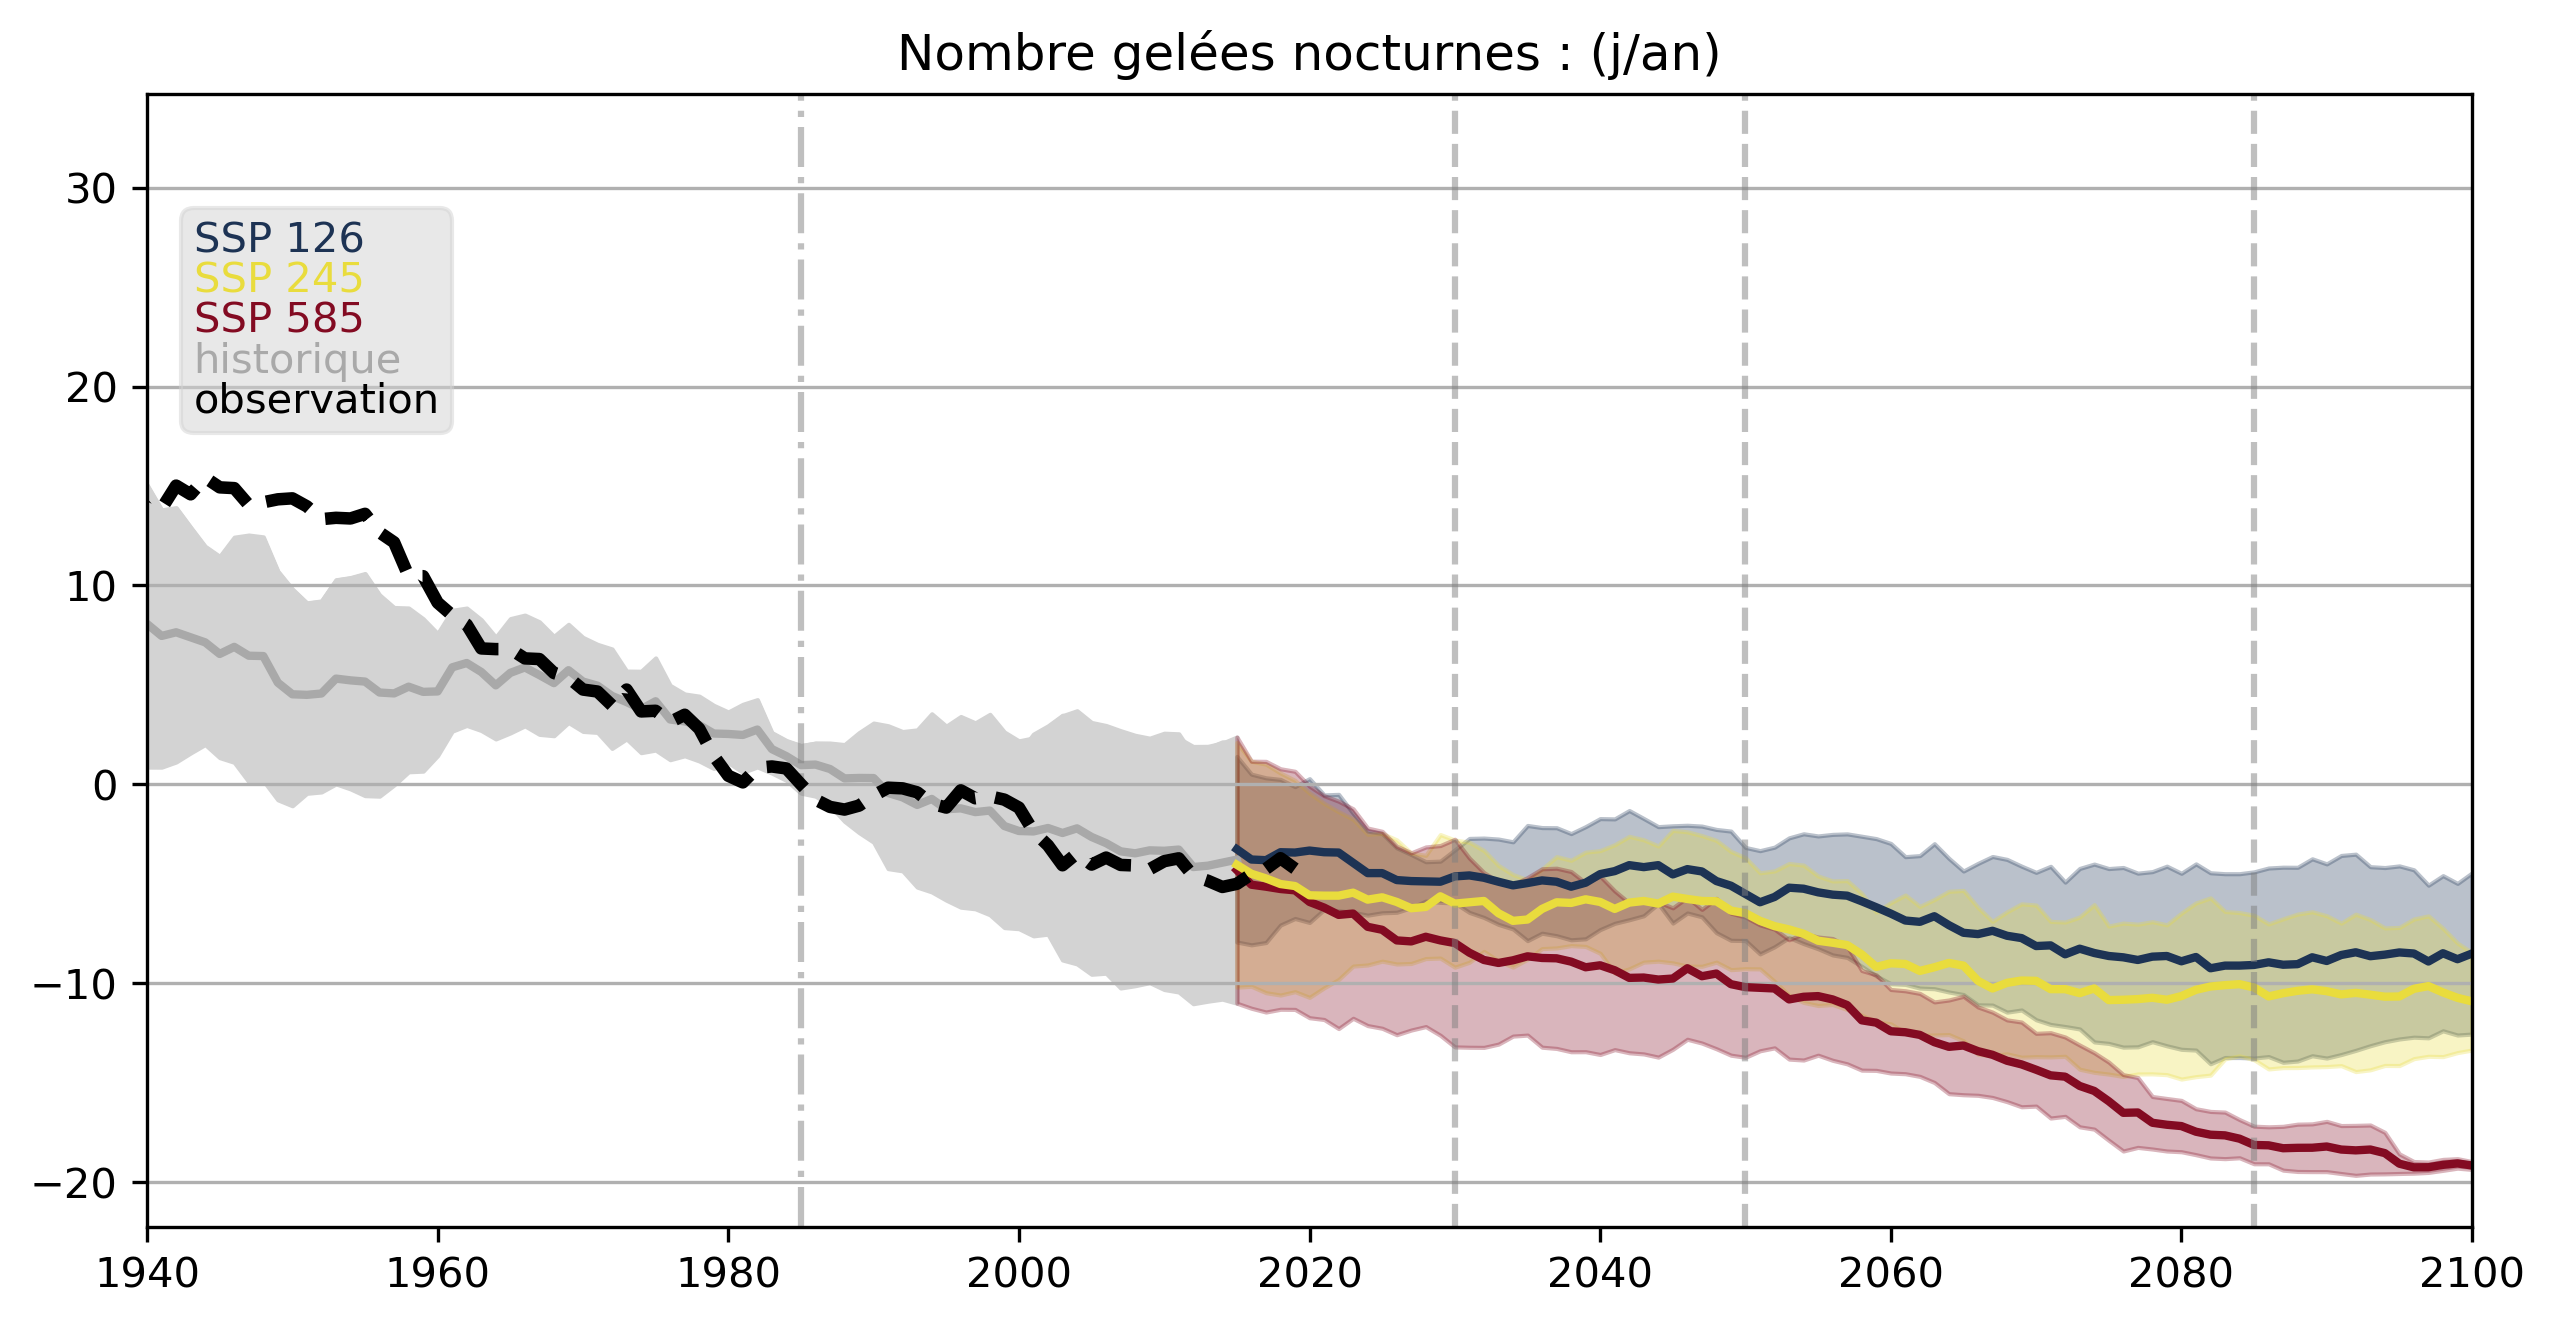

In [95]:
output_png, table_png, csv_file = plot_ssp_uncertainty_anormalie(resource=files, variable=indices[i], title=titles[i], 
                                              observation=observation, decode_cf = False,
                                              figsize=(10, 5),  delta=delta[i],
                                              dir_output=path_pics
                                              )
Image(output_png, width=1000) # , table_png

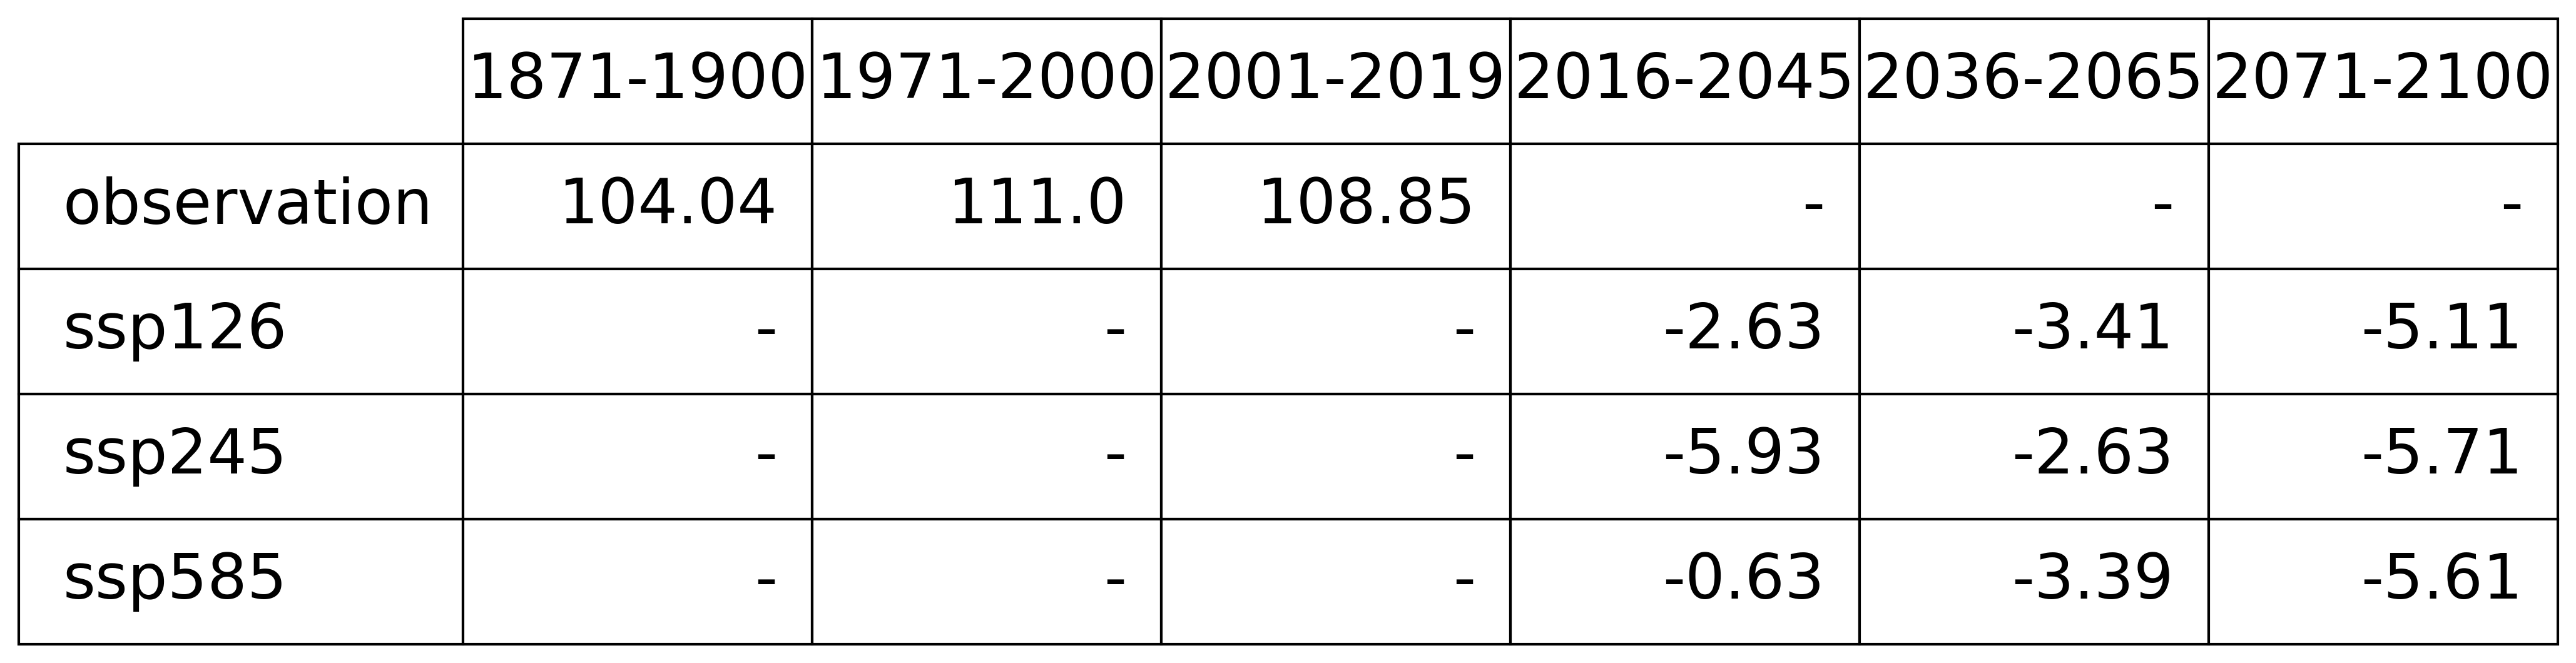

In [24]:
Image(table_png, width=1000)

In [48]:
# df_smooth.plot()

x = pd.to_datetime(df_smooth.index.values)
ts_ref = x.get_loc(dt.strptime("1985", "%Y"), method='nearest')
ref_val = np.nanmean(df_smooth.values, axis=1)[ts_ref]


NameError: name 'df_smooth' is not defined

In [22]:
import numpy
a = numpy.asarray([ [1,2,3], [4,5,6], [7,8,9] ])
numpy.savetxt("foo.csv", a, delimiter=",", header='OBS',)

In [32]:
pd.DataFrame?

In [75]:
# dt = dt.strptime("2016", "%Y")
# if decode_cf is True: 
#                 mi = obs.index
#                 # plt.plot(mi.get_level_values('time'), obs, c='black', lw=1, linestyle='--')
#                 plt.plot(mi.get_level_values('time'), obs_rollmean, c='black', lw=3, linestyle='--' )
#             else:
#                 # plt.plot(x, obs, c='black', lw=1, linestyle='--')
#                 plt.plot(x, obs_rollmean, c='black', lw=3, linestyle='--')
                


In [44]:
ts_ref

135

In [113]:
# ts = dt.strptime("2016", "%Y")
# x.index.get_loc(ts, method='nearest')

In [47]:
x.values[176]

array([nan])

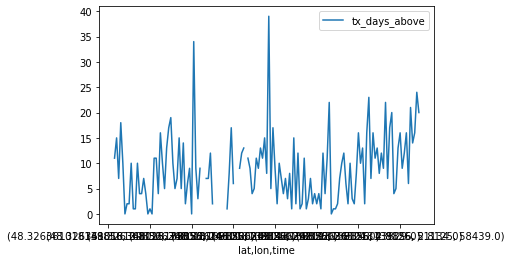

In [154]:
i = 11 # 10  9   8 7  6  5
observation = join(path, '{}_yr_montsouris-observation.nc'.format(indices[i]))
ds = xr.open_dataset(observation, drop_variables='height',  decode_cf=False)
df_obs = ds.to_dataframe()
df_obs.plot()

In [51]:
from birdy import WPSClient
from os import listdir, path

from shutil import move
from os.path import join
fp_url = 'http://localhost:8093'
fp = WPSClient(url=fp_url, progress=True)

In [16]:
def plot_ssp_uncertainty(resource, variable, ylim=None, title=None, observation=None,
                           file_extension='png', delta=0, window=None, dir_output=None,
                           figsize=(10, 10)):
    """
    creates a png file containing the appropriate uncertainty plot.

    :param resource: list of files containing the same variable
    :param delta: set a delta for the values e.g. -273.15 to convert Kelvin to Celsius
    :param variable: variable to be visualised. If None (default), variable will be detected
    :param ylim: Y-axis limitations: tuple(min,max)
    :param title: string to be used as title
    :param observation: 
    :param figsize: figure size defult=(10,10)
    :param window: windowsize of the rolling mean

    :returns str: path/to/file.png
    """
    from flyingpigeon.plt_ncdata import ts_data
    from flyingpigeon.nc_utils import sortssp_by_drsname
    
    try:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, facecolor='w', edgecolor='k', sharey=True)
        plt.subplots_adjust( wspace=0, hspace=0.2) #  

#         fig = plt.figure(figsize=figsize, dpi=600, facecolor='w', edgecolor='k')
    #         LOGGER.debug('Start visualisation spaghetti plot')
    #         === prepare invironment
        if type(resource) != list:
            resource = [resource]
    #         var = get_variable(nc)           
    #         if variable is None:
    #             variable = get_variable(resource[0])
    #         LOGGER.info('plot values preparation done')
    except Exception as ex:
        print("plot values preparation failed {}".format(ex))
    #         LOGGER.exception(msg)
    #         raise Exception(msg)
    try:
        dic = sortssp_by_drsname(resource)  # sort_by_filename(resource, historical_concatination=True)
        df = ts_data(dic, delta=delta)
    except Exception as ex:
        print("failed to sort data".format(e))
        
    ###################################
    # serach datasets according to scenario
    try:
        ssp119 = [ds for ds in df.columns if 'ssp119' in ds]
        ssp126 = [ds for ds in df.columns if 'ssp126' in ds]
        ssp245 = [ds for ds in df.columns if 'ssp245' in ds]
        ssp370 = [ds for ds in df.columns if 'ssp370' in ds]
        ssp434 = [ds for ds in df.columns if 'ssp434' in ds]
        ssp460 = [ds for ds in df.columns if 'ssp460' in ds]
        ssp585 = [ds for ds in df.columns if 'ssp585' in ds]

        print('all scenarios are seperated')
    except Exception as e:
        print('failed to split scenarios {}'.format(e))       


    window = 30 # 30 years

    if len(df.index.values) >= window * 2:
        # TODO: calculate windowsize according to timestapms (day,mon,yr ... with get_frequency)
        df_smooth = df.rolling(window=window, center=True).mean()
        print('rolling mean calculated for all input data')
    else:
        df_smooth = df.copy()
        print('timeseries too short for moving mean')
        fig.text(0.95, 0.05, '!!! timeseries too short for moving mean over 30years !!!',
                 fontsize=20, color='red',
                 ha='right', va='bottom', alpha=0.5)
        
        
        
    try:
        df_ssp119 = df[ssp119].rolling(window=window, center=True, min_periods=2).mean()
        df_ssp126 = df[ssp126].rolling(window=window, center=True, min_periods=2).mean()
        df_ssp245 = df[ssp245].rolling(window=window, center=True, min_periods=2).mean()
        df_ssp370 = df[ssp370].rolling(window=window, center=True, min_periods=2).mean()
        df_ssp434 = df[ssp434].rolling(window=window, center=True, min_periods=2).mean()
        df_ssp460 = df[ssp460].rolling(window=window, center=True, min_periods=2).mean()
        df_ssp585 = df[ssp585].rolling(window=window, center=True, min_periods=2).mean()
    except Exception as e:
        print('failed to group scenarios {}'.format(e))

    
    ####################
    # calculation of mean and uncertainties
    
    # ssp119
    try:
        ssp119_rmean = np.squeeze(df_ssp119.quantile([0.5], axis=1,).values)
        # skipna=False  quantile([0.5], axis=1, numeric_only=False )
        ssp119_q05 = np.squeeze(df_ssp119.quantile([0.10], axis=1,).values)
        ssp119_q33 = np.squeeze(df_ssp119.quantile([0.33], axis=1,).values)
        ssp119_q66 = np.squeeze(df_ssp119.quantile([0.66], axis=1,).values)
        ssp119_q95 = np.squeeze(df_ssp119.quantile([0.90], axis=1,).values)
        print('quantile calculated for all input ssp119 data')
    except Exception as e:
        print('failed to calculate quantiles: {}'.format(e))

    
    # ssp126
    try:
        ssp126_rmean = np.squeeze(df_ssp126.quantile([0.5], axis=1,).values)
        # skipna=False  quantile([0.5], axis=1, numeric_only=False )
        ssp126_q05 = np.squeeze(df_ssp126.quantile([0.10], axis=1,).values)
        ssp126_q33 = np.squeeze(df_ssp126.quantile([0.33], axis=1,).values)
        ssp126_q66 = np.squeeze(df_ssp126.quantile([0.66], axis=1,).values)
        ssp126_q95 = np.squeeze(df_ssp126.quantile([0.90], axis=1,).values)
        print('quantile calculated for all input ssp126 data')
    except Exception as e:
        print('failed to calculate quantiles: {}'.format(e))
   
    # ssp245
    try:
        ssp245_rmean = np.squeeze(df_ssp245.quantile([0.5], axis=1,).values)
        # skipna=False  quantile([0.5], axis=1, numeric_only=False )
        ssp245_q05 = np.squeeze(df_ssp245.quantile([0.10], axis=1,).values)
        ssp245_q33 = np.squeeze(df_ssp245.quantile([0.33], axis=1,).values)
        ssp245_q66 = np.squeeze(df_ssp245.quantile([0.66], axis=1,).values)
        ssp245_q95 = np.squeeze(df_ssp245.quantile([0.90], axis=1,).values)
        print('quantile calculated for all input ssp245 data')
    except Exception as e:
        print('failed to calculate quantiles: {}'.format(e))

    # ssp370
    try:
        ssp370_rmean = np.squeeze(df_ssp370.quantile([0.5], axis=1,).values)
        # skipna=False  quantile([0.5], axis=1, numeric_only=False )
        ssp370_q05 = np.squeeze(df_ssp370.quantile([0.10], axis=1,).values)
        ssp370_q33 = np.squeeze(df_ssp370.quantile([0.33], axis=1,).values)
        ssp370_q66 = np.squeeze(df_ssp370.quantile([0.66], axis=1,).values)
        ssp370_q95 = np.squeeze(df_ssp370.quantile([0.90], axis=1,).values)
        print('quantile calculated for all input ssp370 data')
    except Exception as e:
        print('failed to calculate quantiles: {}'.format(e))
        
    # ssp460
    try:
        ssp460_rmean = np.squeeze(df_ssp460.quantile([0.5], axis=1,).values)
        # skipna=False  quantile([0.5], axis=1, numeric_only=False )
        ssp460_q05 = np.squeeze(df_ssp460.quantile([0.10], axis=1,).values)
        ssp460_q33 = np.squeeze(df_ssp460.quantile([0.33], axis=1,).values)
        ssp460_q66 = np.squeeze(df_ssp460.quantile([0.66], axis=1,).values)
        ssp460_q95 = np.squeeze(df_ssp460.quantile([0.90], axis=1,).values)
        print('quantile calculated for all input ssp460 data')
    except Exception as e:
        print('failed to calculate quantiles: {}'.format(e))
        
    # ssp585
    try:
        ssp585_rmean = np.squeeze(df_ssp585.quantile([0.5], axis=1,).values)
        # skipna=False  quantile([0.5], axis=1, numeric_only=False )
        ssp585_q05 = np.squeeze(df_ssp585.quantile([0.10], axis=1,).values)
        ssp585_q33 = np.squeeze(df_ssp585.quantile([0.33], axis=1,).values)
        ssp585_q66 = np.squeeze(df_ssp585.quantile([0.66], axis=1,).values)
        ssp585_q95 = np.squeeze(df_ssp585.quantile([0.90], axis=1,).values)
        print('quantile calculated for all input ssp585 data')
    except Exception as e:
        print('failed to calculate quantiles: {}'.format(e))

    
    ###################
    # plot 
    
    try:
        x = pd.to_datetime(df.index.values)
#                df[(df['date'] > '2000-6-1') & (df['date'] <= '2000-6-10')] 
        x1 = x[x <= dt.strptime('2015-12-31', "%Y-%m-%d")]
        x2 = x[len(x1)-1:]  # -1 to catch up with the last historical value

        ax1.fill_between(x, ssp126_q05, ssp126_q95, alpha=1, color='lightgrey')
        ax1.fill_between(x, ssp245_q05, ssp245_q95, alpha=1, color='lightgrey')
        ax1.fill_between(x, ssp370_q05, ssp370_q95, alpha=1, color='lightgrey')
        ax1.fill_between(x, ssp460_q05, ssp460_q95, alpha=1, color='lightgrey')
        ax1.fill_between(x, ssp585_q05, ssp585_q95, alpha=1, color='lightgrey')
        
        
        ax1.fill_between(x, ssp126_q33, ssp126_q66, alpha=1, color='darkgrey')
        ax1.fill_between(x, ssp245_q33, ssp245_q66, alpha=1, color='darkgrey')
        ax1.fill_between(x, ssp370_q33, ssp370_q66, alpha=1, color='darkgrey')
        ax1.fill_between(x, ssp460_q33, ssp460_q66, alpha=1, color='darkgrey')
        ax1.fill_between(x, ssp585_q33, ssp585_q66, alpha=1, color='darkgrey')

        ax1.plot(x1, ssp126_rmean[:len(x1)], c='dimgrey', lw=2)
        
        ax1.plot(x2, ssp585_rmean[len(x1)-1:], c=SSP_colors['ssp585'], lw=2)
        ax1.plot(x2, ssp460_rmean[len(x1)-1:], c=SSP_colors['ssp460'], lw=2)
#         plt.plot(x2, ssp370_rmean[len(x1)-1:], c='#63bce4', lw=2)
        ax1.plot(x2, ssp370_rmean[len(x1)-1:], c=SSP_colors['ssp370'], lw=2)
        ax1.plot(x2, ssp245_rmean[len(x1)-1:], c=SSP_colors['ssp245'], lw=2)
        ax1.plot(x2, ssp126_rmean[len(x1)-1:], c=SSP_colors['ssp126'], lw=2)
        ax1.plot(x2, ssp119_rmean[len(x1)-1:], c=SSP_colors['ssp119'], lw=2)
        
        left = 0.1
        bottom = 0.1
        top = 0.8
        right = 0.8
            
        ref_start = dt.strptime('1971-01-01', "%Y-%m-%d")
        ref_end = dt.strptime('2000-12-31', "%Y-%m-%d")
        
        ref_start2 = dt.strptime('1985-01-01', "%Y-%m-%d")
        ref_end2 = dt.strptime('2015-12-31', "%Y-%m-%d")        

        
        ##############################
        ## include les reference lines    
        
        try: 
            ref= np.nanmedian(np.mean(df[(df.index >= ref_start ) 
                                    & (df.index <= ref_end)])) 
            print('ref = {}'.format(ref))
            
#             ax1.hlines(ref, ref_start, ref_end, 
#                    colors='k', linestyles='solid',
#                    label='reference')
            
            ax2.hlines(ref, 1.2, 7.5 , colors='grey', linestyles='solid',
                       label='reference')
            
        except Exception as e: 
            print('failed to get the mean {}'.format(e))
            
        print('timeseries uncertainty plot done for %s' % variable)
    except Exception as e:
        raise Exception('failed to calculate quantiles. {}'.format(e))

    try:
        
        # ax1.plot(x, y)
        # plot(x, -y)

        bp_ref = ax2.boxplot(np.ravel(df[ssp126][len(ssp126_rmean)-131:-101].values),
                             positions = [1], widths = 0.1,
                             whis=(10, 90), sym='', patch_artist=True)

        for box in bp_ref['boxes']:
            # change outline color
#             box.set(color='red', linewidth=2)
            # change fill color
            box.set(facecolor = 'lightgrey' )
            # change hatch
#             box.set(hatch = '/') 
            
        # 2030
        bplots = ax2.boxplot([np.ravel(df[ssp126][len(ssp126_rmean)-85:-55].values),
                             np.ravel(df[ssp245][len(ssp126_rmean)-85:-55].values),
                             np.ravel(df[ssp460][len(ssp126_rmean)-85:-55].values),
                             np.ravel(df[ssp370][len(ssp126_rmean)-85:-55].values),
                             np.ravel(df[ssp585][len(ssp126_rmean)-85:-55].values)],
                             positions = [3.8,3.9,4,4.1,4.2], widths = 0.1,
                             whis=(10, 90), sym='', patch_artist=True) # , ssp370_rmean    
        plt.setp(bplots['boxes'][0], color=SSP_colors['ssp126'])
        plt.setp(bplots['boxes'][1], color=SSP_colors['ssp245'])
        plt.setp(bplots['boxes'][2], color=SSP_colors['ssp460'])
        plt.setp(bplots['boxes'][3], color=SSP_colors['ssp370'])
        plt.setp(bplots['boxes'][4], color=SSP_colors['ssp585'])
        
        bplots = ax2.boxplot([np.ravel(df[ssp126][len(ssp126_rmean)-66:-35].values),
                             np.ravel(df[ssp245][len(ssp126_rmean)-66:-35].values),
                             np.ravel(df[ssp460][len(ssp126_rmean)-66:-35].values),
                             np.ravel(df[ssp370][len(ssp126_rmean)-66:-35].values),
                             np.ravel(df[ssp585][len(ssp126_rmean)-66:-35].values)],
                             positions = [4.8,4.9,5,5.1,5.2], widths = 0.1,
                             whis=(10, 90), sym='', patch_artist=True) 
        plt.setp(bplots['boxes'][0], color=SSP_colors['ssp126'])
        plt.setp(bplots['boxes'][1], color=SSP_colors['ssp245'])
        plt.setp(bplots['boxes'][2], color=SSP_colors['ssp460'])
        plt.setp(bplots['boxes'][3], color=SSP_colors['ssp370'])
        plt.setp(bplots['boxes'][4], color=SSP_colors['ssp585'])
        
        bplots = ax2.boxplot([np.ravel(df[ssp126][len(ssp126_rmean)-31:-1].values),
                             np.ravel(df[ssp245][len(ssp126_rmean)-31:-1].values),
                             np.ravel(df[ssp460][len(ssp126_rmean)-31:-1].values),
                             np.ravel(df[ssp370][len(ssp126_rmean)-31:-1].values),
                             np.ravel(df[ssp585][len(ssp126_rmean)-31:-1].values)],
                             positions = [6.8,6.9,7,7.1,7.2], widths = 0.1, 
                             whis=(10, 90), sym='', patch_artist=True) 
        plt.setp(bplots['boxes'][0], color=SSP_colors['ssp126'])
        plt.setp(bplots['boxes'][1], color=SSP_colors['ssp245'])
        plt.setp(bplots['boxes'][2], color=SSP_colors['ssp460'])
        plt.setp(bplots['boxes'][3], color=SSP_colors['ssp370'])
        plt.setp(bplots['boxes'][4], color=SSP_colors['ssp585'])
        

        from matplotlib.offsetbox import TextArea, VPacker, AnnotationBbox
#         from pylab import *
#         fig = figure(1)
#         ax = gca()
        texts = ['SSP 126','SSP 245','SSP 460','SSP 370','SSP 585']
        colors = [SSP_colors['ssp126'],SSP_colors['ssp245'],SSP_colors['ssp460'],SSP_colors['ssp370'],SSP_colors['ssp585']]
        Texts = []
        for t,c in zip(texts,colors):
            Texts.append(TextArea(t,textprops=dict(color=c)))
        texts_vbox = VPacker(children=Texts,pad=0,sep=0)
        ann = AnnotationBbox(texts_vbox,(.02,.8), xycoords=ax1.transAxes,
                             box_alignment=(0,.5),
                             bboxprops = dict(facecolor='red',boxstyle='round',color='darkgrey'))
        ann.set_figure(fig)
        fig.artists.append(ann)

        fig.suptitle(title, fontsize=15)
        
        plt.yticks(fontsize=16,)
        plt.ylim(ylim)
       
        ax1.set_xlim(dt.strptime('1900-01-01', "%Y-%m-%d"), dt.strptime('2100-01-02', "%Y-%m-%d"))
        
#         ax1.set_xticks(fontsize=16, rotation=45) # ax1.set_xticklabels(rotation=45, fontsize=12)
        ax1.grid(axis='y')  # .grid_line_alpha=0.3

        
        bp_ticks = [1,4,5,7]
        bp_labels = ['ref71-2000','2015-45','2035-65', '2071-2100']

        ax2.set_xticks(bp_ticks)
        ax2.set_xticklabels(bp_labels, rotation=45, fontsize=12)
#         ax2.set_xlables
        ax2.spines['left'].set_visible(False)

        # setBoxColors(bp)
        # bd = plt.boxplot(ssp370_rmean[len(ssp126_rmean)-45:-15], positions = [4], widths = 0.1, ) # , ssp370_rmean 
        # bd = plt.boxplot(ssp585_rmean[len(ssp126_rmean)-45:-15], positions = [5], widths = 0.1) # , ssp370_rmean 
        # setBoxColors(bp)         
        
    except Exception as e:
        raise Exception('Failed to make boxplots. {}'.format(e))
        
    try:    
        output_png = fig2plot(fig=fig, file_extension=file_extension, dir_output=dir_output)
        plt.close()
        
    except Exception as e:
        raise Exception('Failed to make boxplots. {}'.format(e))
        
        
    return output_png

all scenarios are seperated
rolling mean calculated for all input data
quantile calculated for all input ssp119 data
quantile calculated for all input ssp126 data
quantile calculated for all input ssp245 data
quantile calculated for all input ssp370 data
quantile calculated for all input ssp460 data
quantile calculated for all input ssp585 data
ref = 877.0137451171875
timeseries uncertainty plot done for prcptot


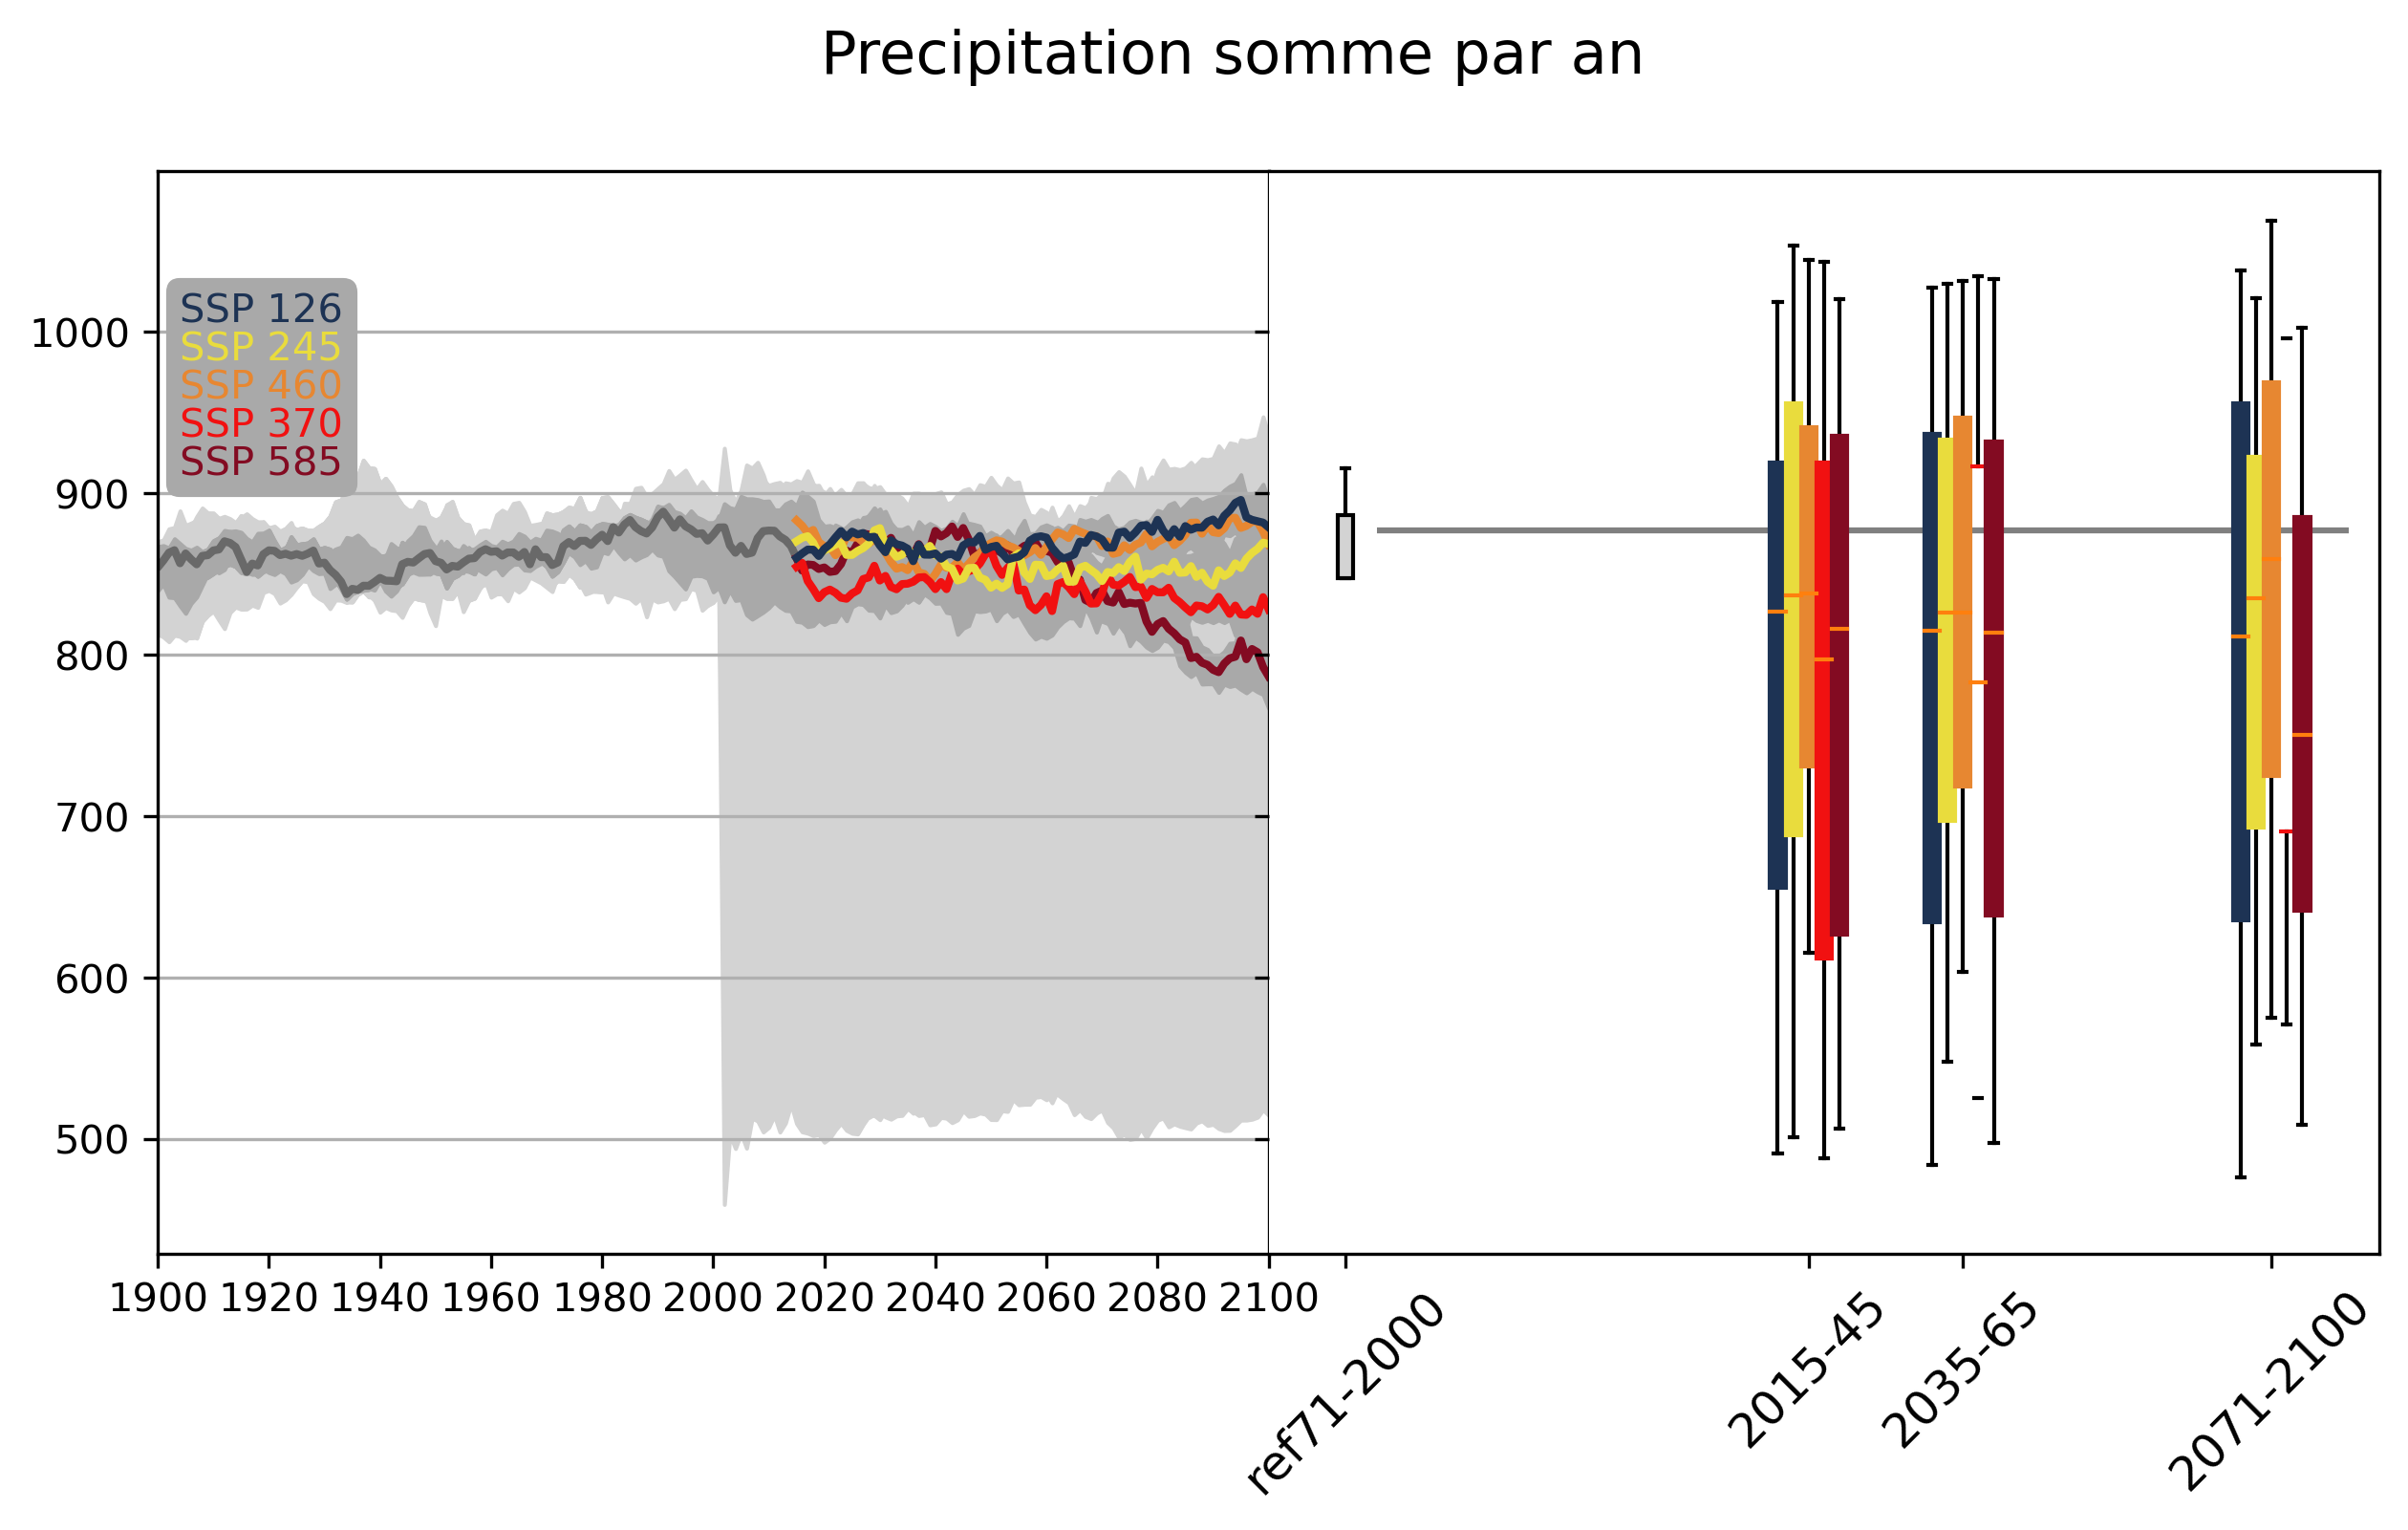

In [64]:
i = 3

indices_files = join(path_indices, indices[i])
files = [join(path_indices,indices[i],f) for f in listdir(indices_files)]

plot = plot_ssp_uncertainty(files, indices[i], title=titles[i], 
                            figsize=(10, 5), delta=-273.15,
                            dir_output=path_pics)

Image(plot, width=1000)

In [61]:
i = 1 # 11 # 10  9   8 7  6  5

indices_files = join(path_indices, indices[i])
files = [join(path_indices,indices[i],f) for f in listdir(indices_files)]

out = fp.plot_spaghetti(files, title=titles[i], figsize=(10, 5))

 owslib.wps.WPSException : {'code': 'NoApplicableCode', 'locator': 'None', 'text': "Process error: method=wps_plot_spaghetti.py._handler, line=162, msg=spaghetti plot failed : plot values preparation failed from_bounds() missing 1 required positional argument: 'height'"}


In [19]:
from flyingpigeon.plt_ncdata import ts_data
from flyingpigeon.nc_utils import sortssp_by_drsname
    
# dic = sortssp_by_drsname(files)  # sort_by_filename(resource, historical_concatination=True)
# df = ts_data(dic, delta=delta)


In [55]:
out.get()

plot_spaghettiResponse(
    plotout_spaghetti='http://127.0.0.1:8093/outputs/cf23803a-dc9d-11ea-9ff5-9cb6d08a53e7/tmptgslcj61.png'
)

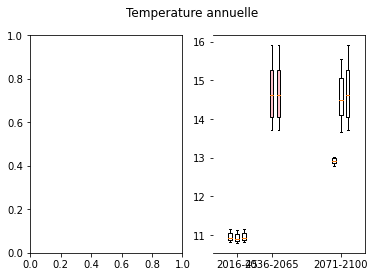

In [175]:
def setBoxColors(bp):
    plt.setp(bp['boxes'][0], color='blue')
    plt.setp(bp['caps'][0], color='blue')
    plt.setp(bp['caps'][1], color='blue')
    plt.setp(bp['whiskers'][0], color='blue')
    plt.setp(bp['whiskers'][1], color='blue')
#     plt.setp(bp['fliers'][0], color='blue')
#     plt.setp(bp['fliers'][1], color='blue')
    plt.setp(bp['medians'][0], color='blue')

    plt.setp(bp['boxes'][1], color='red')
    plt.setp(bp['caps'][2], color='red')
    plt.setp(bp['caps'][3], color='red')
    plt.setp(bp['whiskers'][2], color='red')
    plt.setp(bp['whiskers'][3], color='red')
#     plt.setp(bp['fliers'][2], color='red')
#     plt.setp(bp['fliers'][3], color='red')
    plt.setp(bp['medians'][1], color='red')

ref_start = dt.strptime('1971-01-01', "%Y-%m-%d")
ref_end = dt.strptime('2000-12-31', "%Y-%m-%d")

# fig, axes = plt.subplots(ncols=3, sharey=True)
# fig.subplots_adjust(wspace=0)

# ax.boxplot([data[name][item] ssp126_rmean[len(ssp126_rmean)-45:-15]
            
#             for item in ['A', 'B', 'C']])
# ax.set(xticklabels=['A', 'B', 'C'], xlabel=name)
# ax.margins(0.05) # Optional


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Temperature annuelle')

# ax1.plot(x, y)
# plot(x, -y)

bplots = ax2.boxplot([ssp126_rmean[len(ssp126_rmean)-145:-115], 
                  ssp370_rmean[len(ssp126_rmean)-145:-115],
                  ssp585_rmean[len(ssp126_rmean)-145:-115]],
                  positions = [0.8,1,1.2], widths = 0.1) # , ssp370_rmean 


# bplots['boxes'][0].set_fa

# # fill with colors
# colors = ['pink', 'lightblue', 'lightgreen']

bplot1 = ax2.boxplot(ssp585_rmean[len(ssp585_rmean)-45:-15],
                 positions = [2], widths = 0.1, patch_artist=True)

bplot2 = ax2.boxplot(ssp585_rmean[len(ssp585_rmean)-45:-15],
                 positions = [2.2], widths = 0.1, patch_artist=True)

# # colors = 
# for bp in (bd1,bd2) :
#     for patch, color in zip(bp['boxes'], ['blue','green']):
#         patch.set_facecolor(color)

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        
        

bd = ax2.boxplot([ssp126_rmean[len(ssp126_rmean)-45:-15], 
                  ssp370_rmean[len(ssp126_rmean)-45:-15],
                  ssp585_rmean[len(ssp126_rmean)-45:-15]],
                 positions = [3.8,4,4.2], widths = 0.1) # , ssp370_rmean 

# bp['boxes'][0,1,2], color='red'

ticks = [1,2,4]
labels = ['2016-45','2036-2065' , '2071-2100']

# ax2.xlable
plt.xticks(ticks, labels)

ax2.spines['left'].set_visible(False)

# setBoxColors(bp)
# bd = plt.boxplot(ssp370_rmean[len(ssp126_rmean)-45:-15], positions = [4], widths = 0.1, ) # , ssp370_rmean 

# bd = plt.boxplot(ssp585_rmean[len(ssp126_rmean)-45:-15], positions = [5], widths = 0.1) # , ssp370_rmean 
# setBoxColors(bp)

In [177]:
for key , values in bplot1.items():
    for medline in bplot1[key]:
        try:
            linedata = medline.get_xdata()
            print( '{} : {}'.format(key, linedata) )
        except Exception as e:
            print('failed to get data')

whiskers : [2. 2.]
whiskers : [2. 2.]
caps : [1.975 2.025]
caps : [1.975 2.025]
failed to get data
medians : [1.95 2.05]
fliers : []


In [176]:
for key, value in bplot1.items():
    val = [v.get_data() for v in value]
    print(key, val )

# ['medians']
# res = {key : [v.get_data() for v in value] for key, value in bplot1.items()}

whiskers [(array([2., 2.]), array([14.05755857, 13.72003886])), (array([2., 2.]), array([15.26835963, 15.91097972]))]
caps [(array([1.975, 2.025]), array([13.72003886, 13.72003886])), (array([1.975, 2.025]), array([15.91097972, 15.91097972]))]


AttributeError: 'PathPatch' object has no attribute 'get_data'

In [168]:
bplot1.items()

dict_items([('whiskers', [<matplotlib.lines.Line2D object at 0x7f6409aa67d0>, <matplotlib.lines.Line2D object at 0x7f6409aa6d50>]), ('caps', [<matplotlib.lines.Line2D object at 0x7f6409abc2d0>, <matplotlib.lines.Line2D object at 0x7f6409abc810>]), ('boxes', [<matplotlib.patches.PathPatch object at 0x7f640a1e90d0>]), ('medians', [<matplotlib.lines.Line2D object at 0x7f6409abcd10>]), ('fliers', [<matplotlib.lines.Line2D object at 0x7f6409a8f250>]), ('means', [])])

In [171]:
medline.

In [20]:
def plot_ssp_uncertainty_reduced(resource, variable, ylim=None, title=None, observation=None, decode_cf=True,
                                 file_extension='png', delta=0, window=None, dir_output=None,
                                 figsize=(10, 10)):
    """
    creates a png file containing the appropriate uncertainty plot.

    :param resource: list of files containing the same variable
    :param delta: set a delta for the values e.g. -273.15 to convert Kelvin to Celsius
    :param variable: variable to be visualised. If None (default), variable will be detected
    :param ylim: Y-axis limitations: tuple(min,max)
    :param title: string to be used as title
    :param observation: optional data of observations
    :param figsize: figure size defult=(10,10)
    :param decode_cf: decode of netCDF values according cf convention 
    :param window: windowsize of the rolling mean

    :returns str: path/to/file.png
    """
    from flyingpigeon.plt_ncdata import ts_data
    from flyingpigeon.nc_utils import sortssp_by_drsname
    
    try:
        fig = plt.figure(figsize=figsize, facecolor='w', edgecolor='k')
        ax = fig.add_subplot(111)
#         plt.subplots_adjust( wspace=0, hspace=0.2) #  

#         fig = plt.figure(figsize=figsize, dpi=600, facecolor='w', edgecolor='k')
    #         LOGGER.debug('Start visualisation spaghetti plot')
    #         === prepare invironment
        if type(resource) != list:
            resource = [resource]
    #         var = get_variable(nc)           
    #         if variable is None:
    #             variable = get_variable(resource[0])
    #         LOGGER.info('plot values preparation done')
    except Exception as ex:
        print("plot values preparation failed {}".format(ex))
    #         LOGGER.exception(msg)
    #         raise Exception(msg)
    try:
        dic = sortssp_by_drsname(resource)  # sort_by_filename(resource, historical_concatination=True)
        df = ts_data(dic, delta=delta)
    except Exception as ex:
        print("failed to sort data".format(ex))
        
    ###################################
    # serach datasets according to scenario
    try:
        ssp126 = [ds for ds in df.columns if 'ssp126' in ds]
        ssp245 = [ds for ds in df.columns if 'ssp245' in ds]
        ssp585 = [ds for ds in df.columns if 'ssp585' in ds]

        print('all scenarios are seperated')
    except Exception as e:
        print('failed to split scenarios {}'.format(e))       


    window = 30 # 30 years

    if len(df.index.values) >= window * 2:
        # TODO: calculate windowsize according to timestapms (day,mon,yr ... with get_frequency)
        df_smooth = df.rolling(window=window, center=True).mean()
        print('rolling mean calculated for all input data')
    else:
        df_smooth = df.copy()
        fig.text(0.95, 0.05, '!!! timeseries too short for moving mean over 30years !!!',
                 fontsize=20, color='red',
                 ha='right', va='bottom', alpha=0.5)
        
    try:
        df_ssp126 = df[ssp126].rolling(window=window, center=True, min_periods=2).mean()
        df_ssp245 = df[ssp245].rolling(window=window, center=True, min_periods=2).mean()
        df_ssp585 = df[ssp585].rolling(window=window, center=True, min_periods=2).mean()
    except Exception as e:
        print('failed to group scenarios {}'.format(e))

    
    ####################
    # calculation of mean and uncertainties
    
    # ssp126
    try:
        ssp126_rmean = np.squeeze(df_ssp126.quantile([0.5], axis=1,).values)
        # skipna=False  quantile([0.5], axis=1, numeric_only=False )
        ssp126_q05 = np.squeeze(df_ssp126.quantile([0.05], axis=1,).values)
        ssp126_q33 = np.squeeze(df_ssp126.quantile([0.33], axis=1,).values)
        ssp126_q66 = np.squeeze(df_ssp126.quantile([0.66], axis=1,).values)
        ssp126_q95 = np.squeeze(df_ssp126.quantile([0.95], axis=1,).values)
        print('quantile calculated for all input ssp126 data')
    except Exception as e:
        print('failed to calculate quantiles: {}'.format(e))
   
    # ssp245
    try:
        ssp245_rmean = np.squeeze(df_ssp245.quantile([0.5], axis=1,).values)
        # skipna=False  quantile([0.5], axis=1, numeric_only=False )
        ssp245_q05 = np.squeeze(df_ssp245.quantile([0.05], axis=1,).values)
        ssp245_q33 = np.squeeze(df_ssp245.quantile([0.33], axis=1,).values)
        ssp245_q66 = np.squeeze(df_ssp245.quantile([0.66], axis=1,).values)
        ssp245_q95 = np.squeeze(df_ssp245.quantile([0.95], axis=1,).values)
        print('quantile calculated for all input ssp245 data')
    except Exception as e:
        print('failed to calculate quantiles: {}'.format(e))

       
    # ssp585
    try:
        ssp585_rmean = np.squeeze(df_ssp585.quantile([0.5], axis=1,).values)
        # skipna=False  quantile([0.5], axis=1, numeric_only=False )
        ssp585_q05 = np.squeeze(df_ssp585.quantile([0.05], axis=1,).values)
        ssp585_q33 = np.squeeze(df_ssp585.quantile([0.33], axis=1,).values)
        ssp585_q66 = np.squeeze(df_ssp585.quantile([0.66], axis=1,).values)
        ssp585_q95 = np.squeeze(df_ssp585.quantile([0.95], axis=1,).values)
        print('quantile calculated for all input ssp585 data')
    except Exception as e:
        print('failed to calculate quantiles: {}'.format(e))

    
    ###################
    # plot 
    
    try:
        x = pd.to_datetime(df.index.values)
#                df[(df['date'] > '2000-6-1') & (df['date'] <= '2000-6-10')] 
        x1 = x[x <= dt.strptime('2015-12-31', "%Y-%m-%d")]
        x2 = x[len(x1)-1:]  # -1 to catch up with the last historical value

#         plt.fill_between(x, ssp126_q05, ssp126_q95, alpha=1, color='lightgrey')
#         plt.fill_between(x, ssp245_q05, ssp245_q95, alpha=1, color='lightgrey')
#         plt.fill_between(x, ssp585_q05, ssp585_q95, alpha=1, color='lightgrey')
        
        plt.fill_between(x1, ssp126_q05[:len(x1)], ssp126_q95[:len(x1)], alpha=1, color='lightgrey')
        plt.fill_between(x1, ssp245_q05[:len(x1)], ssp245_q95[:len(x1)], alpha=1, color='lightgrey')
        plt.fill_between(x1, ssp585_q05[:len(x1)], ssp585_q95[:len(x1)], alpha=1, color='lightgrey')

        
        plt.fill_between(x2, ssp126_q05[len(x1)-1:], ssp126_q95[len(x1)-1:], alpha=0.3, color=SSP_colors['ssp126'])
        plt.fill_between(x2, ssp245_q05[len(x1)-1:], ssp245_q95[len(x1)-1:], alpha=0.3, color=SSP_colors['ssp245'])
        plt.fill_between(x2, ssp585_q05[len(x1)-1:], ssp585_q95[len(x1)-1:], alpha=0.3, color=SSP_colors['ssp585'])

        mean_hist = np.mean([ssp126_rmean[:len(x1)], ssp245_rmean[:len(x1)] , ssp245_rmean[:len(x1)]],axis=0)
        
        plt.plot(x1, mean_hist , c='darkgrey', lw=2)
#         plt.plot(x1, ssp245_rmean[:len(x1)], c='dimgrey', lw=2)
#         plt.plot(x1, ssp245_rmean[:len(x1)], c='dimgrey', lw=2)
        
        plt.plot(x2, ssp585_rmean[len(x1)-1:], c=SSP_colors['ssp585'], lw=2)
        plt.plot(x2, ssp245_rmean[len(x1)-1:], c=SSP_colors['ssp245'], lw=2)
        plt.plot(x2, ssp126_rmean[len(x1)-1:], c=SSP_colors['ssp126'], lw=2)
        
        
    except Exception as e:
        raise Exception('Failed to make plot. {}'.format(e))
        
        
    plt.xlim(dt.strptime('1940-01-01', "%Y-%m-%d"), dt.strptime('2100-01-02', "%Y-%m-%d"))

    #         ax1.set_xticks(fontsize=16, rotation=45) # ax1.set_xticklabels(rotation=45, fontsize=12)
    plt.grid(axis='y')  # .grid_line_alpha=0.3
    
    plt.title(title)
    
    
    from matplotlib.offsetbox import TextArea, VPacker, AnnotationBbox
#         from pylab import *
#         fig = figure(1)
#         ax = gca()
    texts = ['SSP 126','SSP 245','SSP 585','historique', 'observation']
    colors = [SSP_colors['ssp126'],SSP_colors['ssp245'],SSP_colors['ssp585'], 'darkgrey','black']
    Texts = []
    for t,c in zip(texts,colors):
        Texts.append(TextArea(t,textprops=dict(color=c)))
    texts_vbox = VPacker(children=Texts,pad=0,sep=0)
    ann = AnnotationBbox(texts_vbox,(.02,.8), xycoords=ax.transAxes,
                         box_alignment=(0,.5),
                         bboxprops = dict(facecolor='red',boxstyle='round', alpha=0.5, color='lightgrey'))
    ann.set_figure(fig)
    fig.artists.append(ann)

    try:
        plt.axvline(dt.strptime('1985-01-01', "%Y-%m-%d"), color='gray', linestyle='-.', alpha=0.5)
        plt.axvline(dt.strptime('2030-01-01', "%Y-%m-%d"), color='gray', linestyle='--', alpha=0.5)
        plt.axvline(dt.strptime('2050-01-01', "%Y-%m-%d"), color='gray', linestyle='--', alpha=0.5)
        plt.axvline(dt.strptime('2085-01-01', "%Y-%m-%d"), color='gray', linestyle='--', alpha=0.5)
        
    except:
        raise Exception('Failed to make scatters')
    
    # include Observation 
    if observation is not None:
        try:
            import xarray as xr
            
            ds = xr.open_dataset(observation, drop_variables='height', decode_cf=decode_cf)
            if delta == 0: 
                obs = ds.to_dataframe()
            else: 
                obs = ds.to_dataframe() + delta
            
            obs_rollmean = obs.rolling(window=window, center=True, min_periods=16 ).mean() #   closed='right', 
            
            if decode_cf is True: 
                mi = obs.index
                # plt.plot(mi.get_level_values('time'), obs, c='black', lw=1, linestyle='--')
                plt.plot(mi.get_level_values('time'), obs_rollmean, c='black', lw=3, linestyle='--' )
            else:
                # plt.plot(x, obs, c='black', lw=1, linestyle='--')
                plt.plot(x, obs_rollmean, c='black', lw=3, linestyle='--')
            
#             plt.scatter(dt.strptime('1985', "%Y"), 12, c='black', s=20)
#             plt.annotate(12, (dt.strptime('1985', "%Y"), 12), c='red')
            
        except Exception as e:
            raise Exception('Failed to plot observation {}'.format(e))
    try:    
        output_png = fig2plot(fig=fig, file_extension=file_extension, dir_output=dir_output)
        plt.close()
        
    except Exception as e:
        raise Exception('Failed to make boxplots. {}'.format(e))
        
        
    try:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        y = [1, 2, 3, 4, 5, 4, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1]    
        col_labels = ['1971-2000','2016-2045', '2036-2065', '2071-2100']
        row_labels = ['observation', 'hist(moyen)', 'ssp126', 'ssp245' ,'ssp585']
        
        ts_ref = x.get_loc(dt.strptime("1985", "%Y"), method='nearest')
        ts_30 = x.get_loc(dt.strptime("2030", "%Y"), method='nearest')
        ts_50 = x.get_loc(dt.strptime("2050", "%Y"), method='nearest')
        ts_85 = x.get_loc(dt.strptime("2085", "%Y"), method='nearest')
        
        table_vals = [[np.round(obs_rollmean.values[ts_ref],2)[0], '-' , '-', '-'], # [obs_rollmean[ts_ref]
                      [round(mean_hist[ts_ref],2), '-', '-', '-'], 
                      [round(ssp126_rmean[ts_ref],2) , round(ssp126_rmean[ts_30],2), round(ssp126_rmean[ts_50],2),round(ssp126_rmean[ts_85],2)],  # 126
                      [round(ssp245_rmean[ts_ref],2), round(ssp245_rmean[ts_30],2), round(ssp245_rmean[ts_50],2),round(ssp245_rmean[ts_85],2)],
                      [round(ssp585_rmean[ts_ref],2), round(ssp585_rmean[ts_30],2), round(ssp585_rmean[ts_50],2),round(ssp585_rmean[ts_85],2)]
                     ]

        # Draw table
        the_table = plt.table(cellText=table_vals,
                              colWidths=[0.1] * 30,
                              rowLabels=row_labels,
                              colLabels=col_labels,
                              loc='center')
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(24)
        the_table.scale(4, 4)

        # Removing ticks and spines enables you to get the figure only with table
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)

        for pos in ['right','top','bottom','left']:
            plt.gca().spines[pos].set_visible(False)
        table_png = fig2plot(fig=fig, file_extension=file_extension, dir_output=dir_output)
        plt.close()

    except Exception as e:
        raise Exception('Failed to make table. {}'.format(e))
        
        
    return output_png , table_png

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import random

data = {}
data['dataset1'] = {}
data['dataset2'] = {}
data['dataset3'] = {}

n = 500
for k,v in data.keys():
    upper = random.randint(0, 1000)
    v['A'] = np.random.uniform(0, upper, size=n)
    v['B'] = np.random.uniform(0, upper, size=n)
    v['C'] = np.random.uniform(0, upper, size=n)

fig, axes = plt.subplots(ncols=3, sharey=True)
fig.subplots_adjust(wspace=0)

for ax, name in zip(axes, ['dataset1', 'dataset2', 'dataset3']):
    ax.boxplot([data[name][item] for item in ['A', 'B', 'C']])
    ax.set(xticklabels=['A', 'B', 'C'], xlabel=name)
    ax.margins(0.05) # Optional

plt.show()

ValueError: too many values to unpack (expected 2)

TypeError: 'str' object is not callable

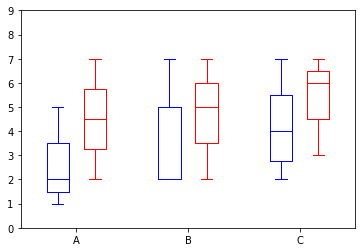

In [16]:

    # Some fake data to plot
A= [[1, 2, 5,],  [7, 2]]
B = [[5, 7, 2, 2, 5], [7, 2, 5]]
C = [[3,2,5,7], [6, 7, 3]]

fig = plt.figure()
ax = plt.axes()
# hold(True)

# first boxplot pair
bp = plt.boxplot(A, positions = [1, 2], widths = 0.6)
setBoxColors(bp)

# second boxplot pair
bp = plt.boxplot(B, positions = [4, 5], widths = 0.6)
setBoxColors(bp)

# thrid boxplot pair
bp = plt.boxplot(C, positions = [7, 8], widths = 0.6)
setBoxColors(bp)

# set axes limits and labels
plt.xlim(0,9)
plt.ylim(0,9)
ax.set_xticklabels(['A', 'B', 'C'])
ax.set_xticks([1.5, 4.5, 7.5])

# draw temporary red and blue lines and use them to create a legend
hB, = plot([1,1],'b-')
hR, = plot([1,1],'r-')
legend((hB, hR),('Apples', 'Oranges'))
hB.set_visible(False)
hR.set_visible(False)

savefig('boxcompare.png')
show()

In [111]:
plot = plot_ssp_spaghetti(resource=files, variable='tg_mean', figsize=(15,3), delta=-273.15)

spaghetti plot failed for /home/nils/ramboll/paris/data/indices/tg-mean/tg-mean_yr_CNRM-CM6-1-HR_ssp245_r1i1p1f2_gr_2065-2100.nc : x and y can be no greater than 2-D, but have shapes (36,) and (36, 2, 3)
spaghetti plot failed for /home/nils/ramboll/paris/data/indices/tg-mean/tg-mean_yr_CNRM-CM6-1-HR_ssp585_r1i1p1f2_gr_2065-2100.nc : x and y can be no greater than 2-D, but have shapes (36,) and (36, 2, 3)
spaghetti plot failed for /home/nils/ramboll/paris/data/indices/tg-mean/tg-mean_yr_CNRM-CM6-1-HR_ssp370_r1i1p1f2_gr_2065-2100.nc : x and y can be no greater than 2-D, but have shapes (36,) and (36, 2, 3)
spaghetti plot failed for /home/nils/ramboll/paris/data/indices/tg-mean/tg-mean_yr_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_2000-2014.nc : x and y can be no greater than 2-D, but have shapes (15,) and (15, 2, 3)
spaghetti plot failed for /home/nils/ramboll/paris/data/indices/tg-mean/tg-mean_yr_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_1900-1949.nc : x and y can be no greater than 2-D, but have 

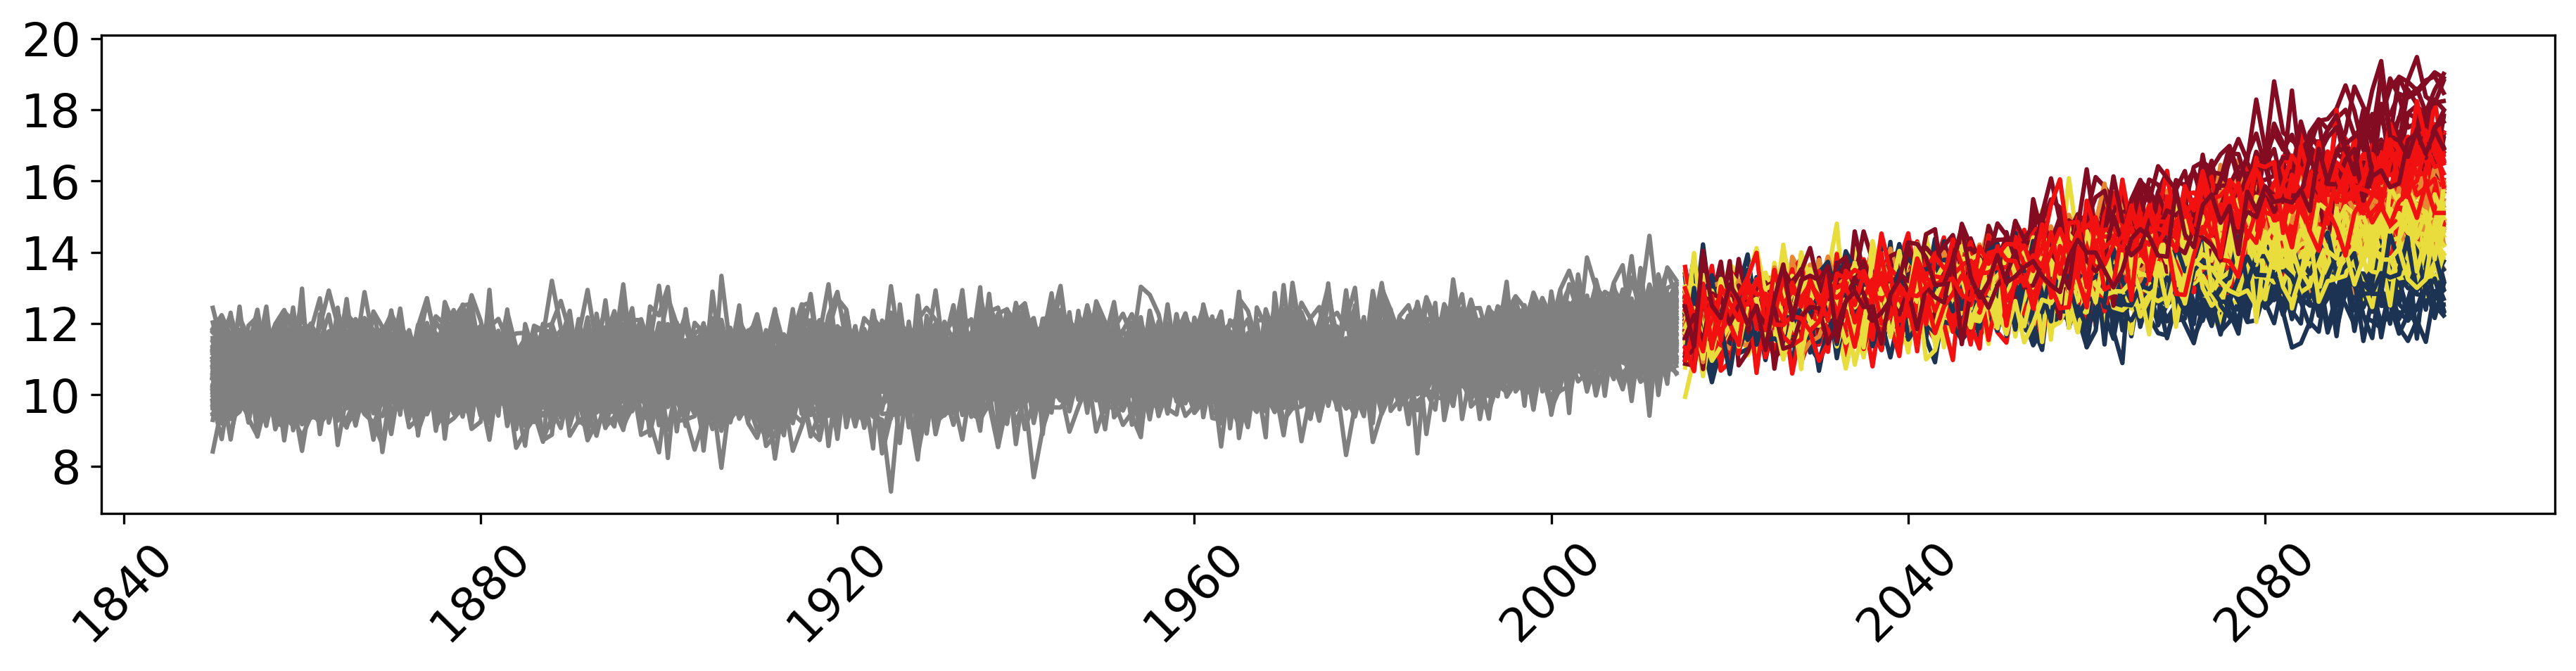

In [112]:
Image(plot)

In [76]:
files = [join('/home/nils/ramboll/paris/data/indices/tg-mean',f) for f in listdir('data/indices/tg-mean')]


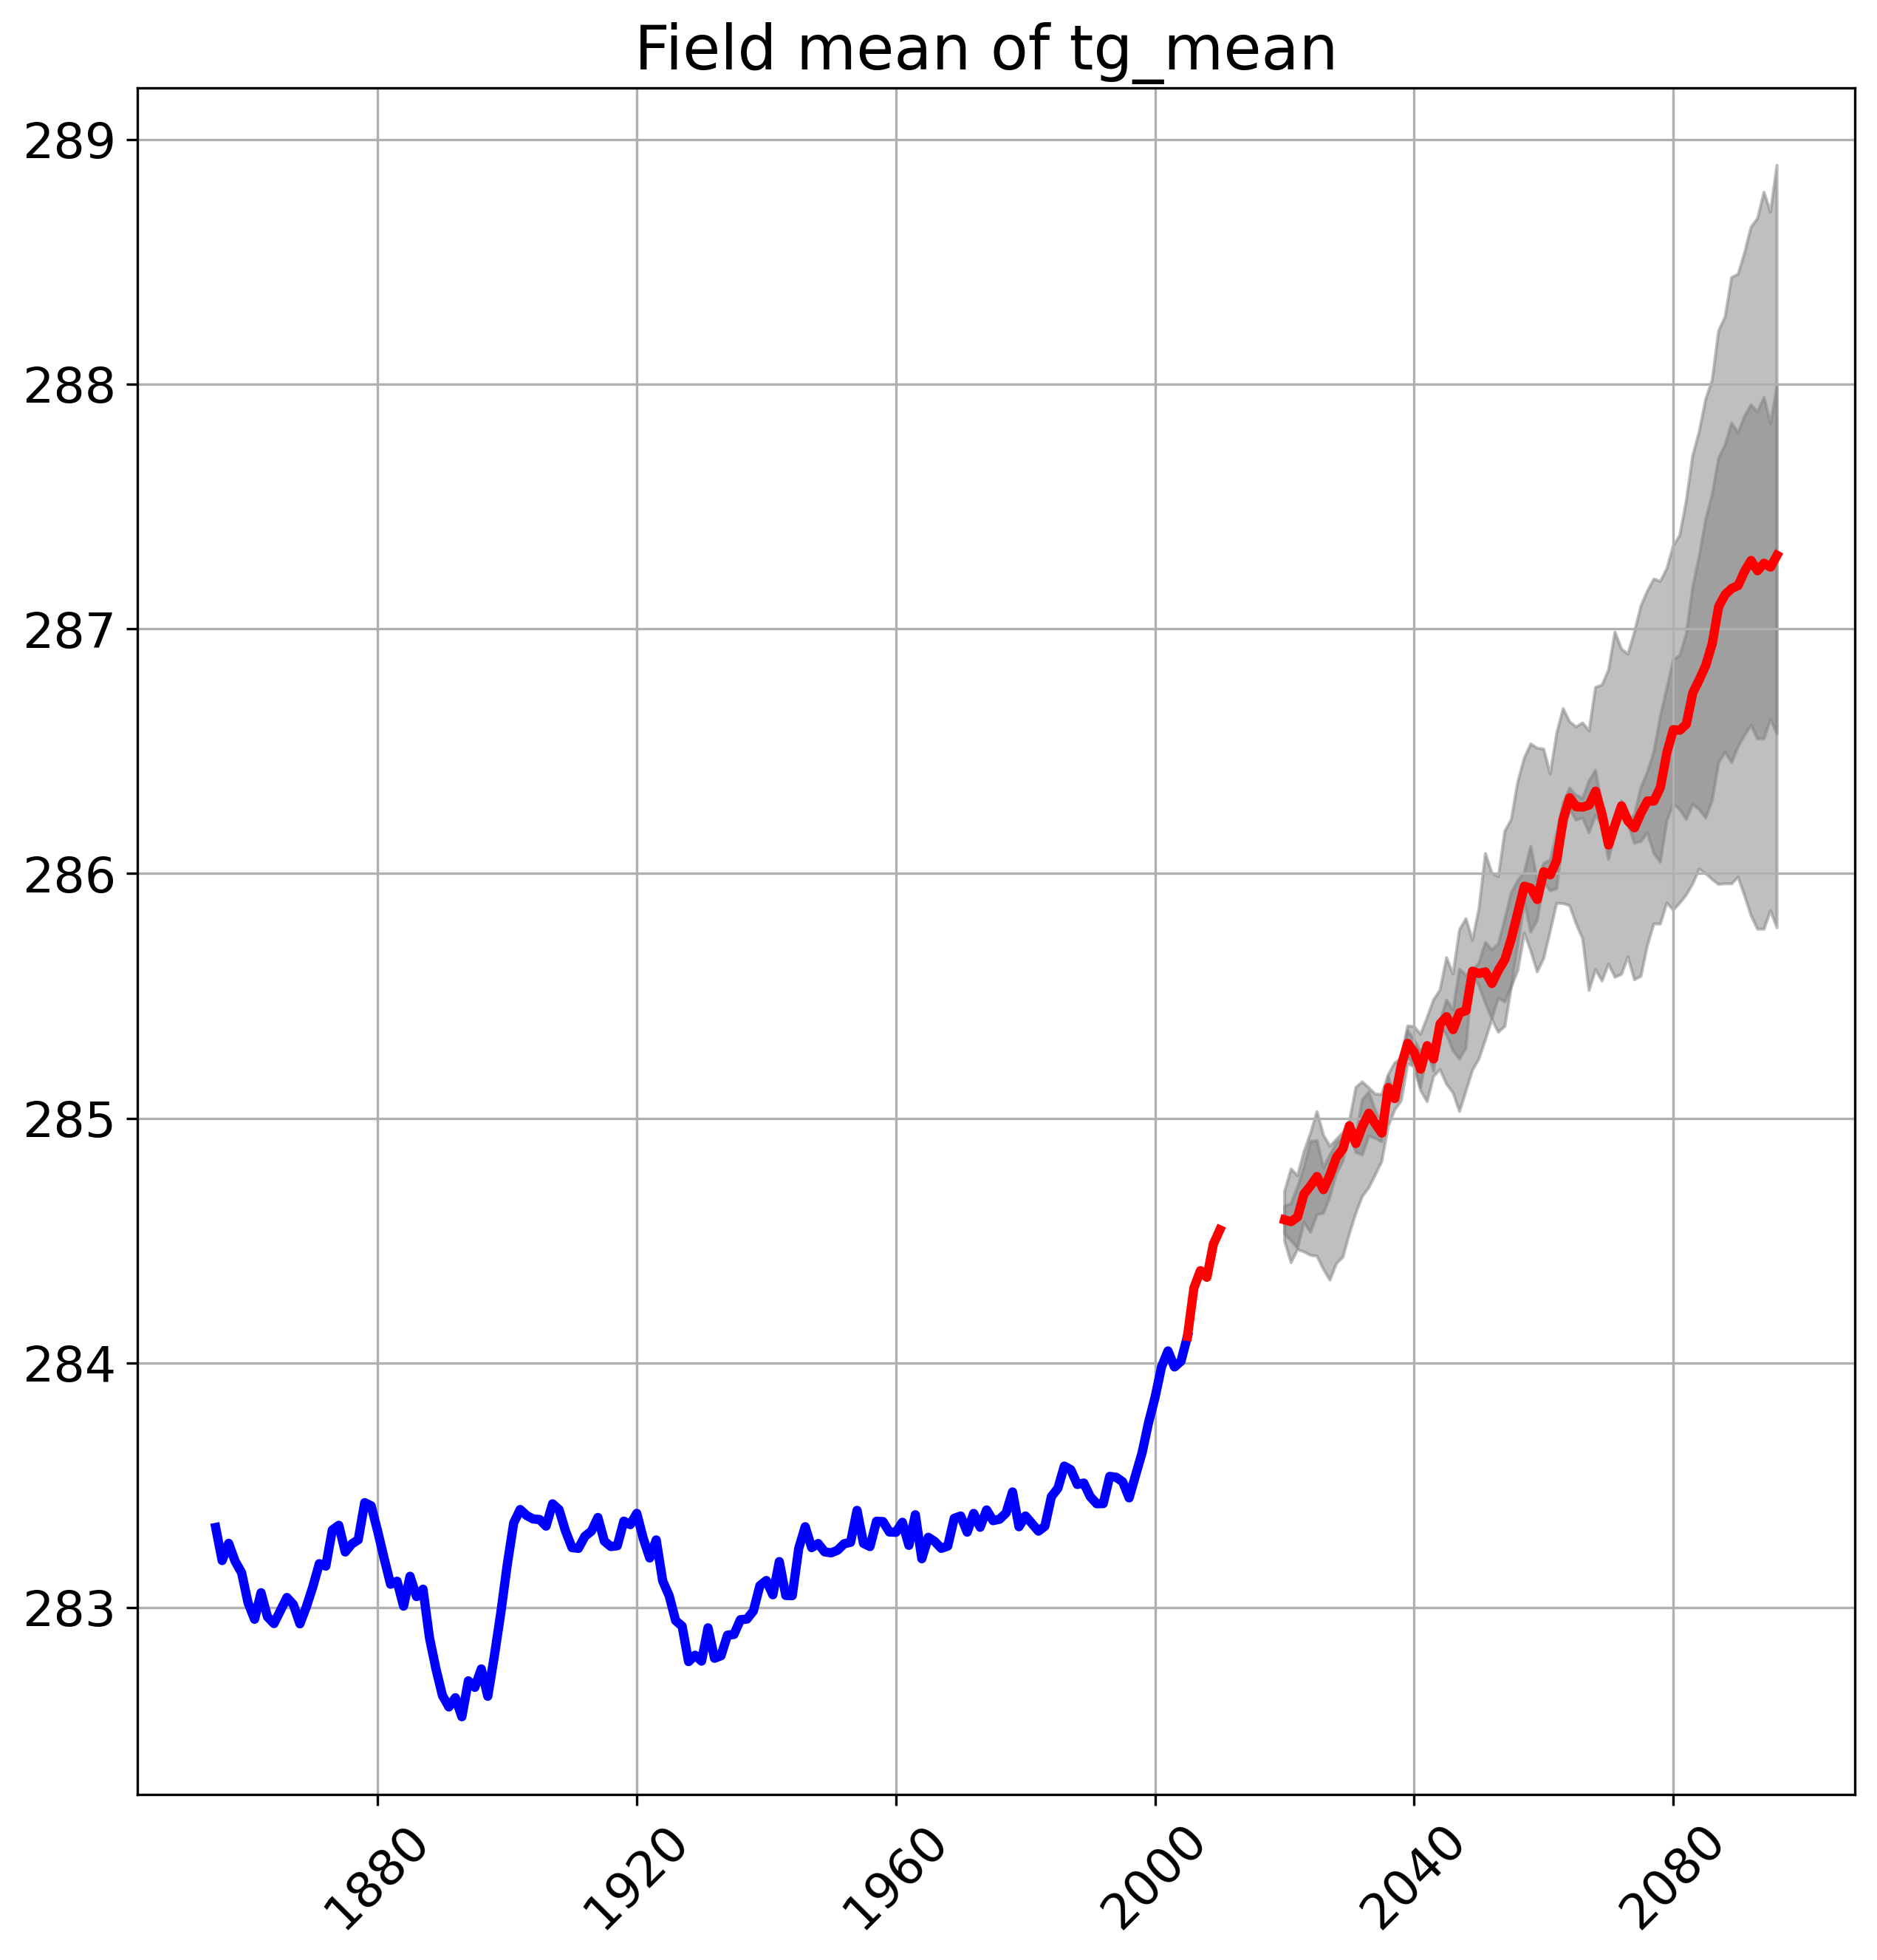

In [14]:
               
#     if len(resource) > 1:
#         LOGGER.debug('sort_by_filename module start sorting %s files' % len(resource))
#         # LOGGER.debug('resource is list with %s files' % len(resource))
#         try:  # if len(resource) > 1:
#             # collect the different experiment names
#             


#             LOGGER.info('found %s datasets', len(nc_datasets.keys()))
#         except Exception:
#             LOGGER.exception('failed to find names of datasets!')
#         LOGGER.info('check for historical/RCP datasets')
#         
# try:
#             if historical_concatination is True:
#                 # select only necessary names
#                 rcp_datasets = nc_datasets.copy()
#                 if any("_rcp" in s for s in nc_datasets.keys()):
#                     for key in nc_datasets.keys():
#                         if 'historical' in key:
#                             rcp_datasets.pop(key)
#                     nc_datasets = rcp_datasets.copy()
#                     LOGGER.info('historical data set names removed from dictionary')
#                 else:
#                     LOGGER.info('no RCP dataset names found in dictionary')
#         except Exception:
#             LOGGER.exception('failed to pop historical data set names!')
#         LOGGER.info('start sorting the files')
#         

# try:
#             for key in nc_datasets:
#                 try:
#                     if historical_concatination is False:
#                         for n in resource:
#                             if '%s_' % key in n:
#                                 nc_datasets[key].append(path.abspath(n))  # path.join(p, n))

#                     elif historical_concatination is True:
#                         key_hist = key.replace('rcp26', 'historical').\
#                             replace('rcp45', 'historical').\
#                             replace('rcp65', 'historical').\
#                             replace('rcp85', 'historical')
#                         for n in resource:
#                             if '{}_'.format(key_hist) in n:
#                                 nc_datasets[key].append(path.abspath(n))
#                             if '{}_'.format(key) in n:
#                                 nc_datasets[key].append(path.abspath(n))  # path.join(p, n))
#                     else:
#                         LOGGER.error('append file paths to dictionary for key %s failed' % key)
#                     nc_datasets[key].sort()
#                 except Exception:
#                     LOGGER.exception('failed for %s ' % key)
#         except Exception:
#             LOGGER.exception('failed to populate the dictionary with appropriate files')
#         for key in nc_datasets.keys():
#             try:
#                 nc_datasets[key].sort()
#                 start, _ = get_timerange(nc_datasets[key][0])  # get first timestep of first file
#                 _, end = get_timerange(nc_datasets[key][-1])  # get last  timestep of last file
#                 newkey = key + '_' + start + '-' + end
#                 tmp_dic[newkey] = nc_datasets[key]
#             except Exception:
#                 msg = 'failed to sort the list of resources and add dates to keyname: %s' % key
#                 LOGGER.exception(msg)
#                 tmp_dic[key] = nc_datasets[key]
#                 # raise Exception(msg)
#     elif len(resource) == 1:
#         p, f = path.split(path.abspath(resource[0]))
#         tmp_dic[f.replace('.nc', '')] = path.abspath(resource[0])
#         LOGGER.debug('only one file! Nothing to sort, resource is passed into dictionary')
#     else:
#         LOGGER.debug('sort_by_filename module failed: resource is not 1 or >1')
#     LOGGER.info('sort_by_filename module done: %s datasets found' % len(nc_datasets))
# except Exception:
#     msg = 'failed to sort files by filename'
#     LOGGER.exception(msg)
#     raise Exception(msg)

    